# Imports and commons 

In [3]:
from utils import add_to_path
add_to_path("/home/avirinchipur/research/LongitudeML/examples/ptsd_stop_forecasting/PCL_forecast_baselines.ipynb")
import time

from datasets import load_from_disk, Dataset
from src import get_datasetDict

import pandas as pd
import numpy as np
from scipy.stats import pearsonr, hmean
from pprint import pprint
import matplotlib.pyplot as plt
import pickle
import torch
from eval import within_seq_metric

Adding directory to path: /home/avirinchipur/research/LongitudeML


In [4]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true).reshape(-1, ), np.array(y_pred).reshape(-1, )
    return 2*np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [5]:
data_dir = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/roberta_base_L11_rpca64_PCL_1_days_ahead_max90days_v3_40combined_5fold"
data = load_from_disk(data_dir)

In [5]:
datasetDict = get_datasetDict(train_data=data, val_folds=[0])

Filter:   0%|          | 0/118 [00:00<?, ? examples/s]

Filter:   0%|          | 0/118 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/96 [00:00<?, ? examples/s]

/cronus_data/conda_envs/emi/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Flattening the indices:   0%|          | 0/22 [00:00<?, ? examples/s]

In [9]:
datasetDict

DatasetDict({
    train: Dataset({
        features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask', 'oots_mask', 'ooss_mask'],
        num_rows: 115
    })
    val: Dataset({
        features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask', 'oots_mask', 'ooss_mask'],
        num_rows: 152
    })
})

## Baselines for 1 day ahead prediction
1. Use the last day's PCL score to predict the next day's PCL score
2. Use the avg of the last three days' PCL score to predict the next day's PCL score
3. Model previous day's language embeddings to predict the next day's PCL score
4. Model last three days' language embeddings to predict the next day's PCL score

In [5]:
"""python dlatkInterface.py -d ptsd_stop -t whisper_transcripts_v3 -c user_day_id --group_freq_thresh 10 
                            -f 'feat$roberta_ba_meL11con$whisper_transcripts_v3$user_day_id' 
                            --outcome_table outcomes_v3_PCL_forecast --outcomes PCL_1_day_ahead 
                            --nfold_regression --folds 10 --model ridgehighcv --controls today_PCL
"""
# TODO fix the stratification

"python dlatkInterface.py -d ptsd_stop -t whisper_transcripts_v3 -c user_day_id --group_freq_thresh 10 \n                            -f 'feat$roberta_ba_meL11con$whisper_transcripts_v3$user_day_id' \n                            --outcome_table outcomes_v3_PCL_forecast --outcomes PCL_1_day_ahead \n                            --nfold_regression --folds 10 --model ridgehighcv --controls today_PCL\n"

In [6]:
datasetDict

DatasetDict({
    train: Dataset({
        features: ['seq_id', 'embeddings', 'num_tokens', 'time_ids', 'infill_lang_mask', 'outcomes', 'infill_outcomes_mask'],
        num_rows: 0
    })
    val: Dataset({
        features: ['seq_id', 'embeddings', 'num_tokens', 'time_ids', 'infill_lang_mask', 'outcomes', 'infill_outcomes_mask'],
        num_rows: 118
    })
})

In [7]:
val_data = datasetDict['val']
val_df = val_data.to_pandas()
val_df

,seq_id,embeddings,num_tokens,time_ids,infill_lang_mask,outcomes,infill_outcomes_mask
0,3612,"[[7.510826892832634, -0.4046889472774059, 1.10...","[444.0, 634.0, nan, 394.0, nan, 527.0, nan, 31...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, ...","[[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[1], [0], [0], [0], [0], [0], [0], [0], [0], ..."
1,1586,"[[-5.946556024017722, -1.3106577150888945, 0.3...","[1224.0, 699.0, nan, 822.0, 334.0, 598.0, 842....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[[1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1....","[[1], [0], [0], [1], [1], [1], [1], [1], [1], ..."
2,2204,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[nan, nan, nan, nan, 405.0, 872.0, 383.0, nan,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[[1.0], [1.125], [1.5], [1.0], [1.0], [1.0], [...","[[1], [1], [1], [1], [1], [1], [0], [0], [1], ..."
3,4142,"[[-9.386885372025203, 12.172111336601672, 3.21...","[474.0, 243.0, 365.0, 454.0, 354.0, 373.0, 407...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1.0], [1.375], [1.0], [1.0], [1.375], [1.0],...","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ..."
4,3763,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[nan, 557.0, 485.0, 730.0, 502.0, 44.0, nan, 8...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...","[[1.125], [1.0], [1.125], [1.0], [1.0], [0.0],...","[[1], [1], [1], [1], [1], [0], [0], [0], [0], ..."
...,...,...,...,...,...,...,...
113,3081,"[[-11.513912549417848, 7.582040320391339, 5.48...","[345.0, 1374.0, 423.0, 761.0, 517.0, 649.0, na...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[3.25], [3.5], [4.0], [3.875], [2.25], [0.0],...","[[1], [1], [1], [1], [1], [0], [0], [1], [1], ..."
114,2780,"[[-5.697550121383508, 2.620948222966577, -1.05...","[846.0, 668.0, 477.0, 738.0, 847.0, 566.0, 577...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[4.875], [3.75], [3.875], [4.625], [4.5], [3....","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ..."
115,3054,"[[-9.549370388153688, 9.261649663906258, -4.58...","[828.0, 602.0, 1052.0, nan, 611.0, 815.0, 581....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[3.125], [2.375], [4.75], [4.125], [4.625], [...","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ..."
116,2825,"[[18.29092881053123, 10.531276636338832, 0.509...","[615.0, 742.0, nan, nan, nan, 511.0, nan, nan,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, ...","[[4.125], [0.0], [0.0], [0.0], [0.0], [4.5], [...","[[1], [0], [0], [0], [0], [1], [1], [0], [0], ..."


In [8]:
def get_outcomes_timeseries(time_ids:list, outcomes:list, outcomes_mask:list):
    """
        Function that turns the series of outcomes into a time series df
    """
    time_ids = np.array(time_ids).reshape(-1, 1)
    outcomes = [outcome[0] for outcome in outcomes]
    outcomes = np.array(outcomes).reshape(-1, 1)
    outcomes_mask = np.array(outcomes_mask).reshape(-1, 1)
    
    # replace the positions with outcomes_mask == 0 with nan in the outcomes
    outcomes = np.where(outcomes_mask == 0, np.nan, outcomes)
    
    df = pd.DataFrame(np.hstack([time_ids, outcomes]), columns=['time_id', 'outcome'])
    
    # add one to time_id since the outcomes are setup for day ahead forecasting
    df['time_id'] = (df['time_id'] + 1).astype(int)
    
    # Assert that time_id between its min and max values is a continuous sequence
    assert set(df['time_id']) == set(range(df['time_id'].min(), df['time_id'].max() + 1)), "Time_id is not a continuous sequence"
    
    return df


def get_ts_shifted_outcomes(df:pd.DataFrame, shifts:list=[-1]):
    """
        Modifies the dataframe to have time shifted outcomes.
    """
    
    for shift in shifts:
        df[f'outcome_shift_{shift}'] = df['outcome'].shift(shift)
    return df


outcomes_ts_df = get_outcomes_timeseries(val_df.iloc[0]['time_ids'], val_df.iloc[0]['outcomes'], val_df.iloc[0]['infill_outcomes_mask'])
outcomes_ts_df_prev1 = get_ts_shifted_outcomes(outcomes_ts_df.copy(), shifts=[1])
outcomes_ts_df_prev1 = outcomes_ts_df_prev1.rename(columns={'outcome_shift_1': 'prev1_outcome'})
outcomes_ts_df_prev3 = get_ts_shifted_outcomes(outcomes_ts_df.copy(), shifts=[1, 2, 3])
outcomes_ts_df_prev3 = outcomes_ts_df_prev3.rename(columns={'outcome_shift_1': 'prev1_outcome', 'outcome_shift_2': 'prev2_outcome', 'outcome_shift_3': 'prev3_outcome'})

In [9]:
last1_baseline_data = []
last3_baseline_data = []
for idx, row in val_df.iterrows():
    outcomes_ts_df = get_outcomes_timeseries(row['time_ids'], row['outcomes'], row['infill_outcomes_mask'])
    outcomes_ts_df_prev1 = get_ts_shifted_outcomes(outcomes_ts_df.copy(), shifts=[1])
    outcomes_ts_df_prev1 = outcomes_ts_df_prev1.rename(columns={'outcome_shift_1': 'prev1_outcome'})
    temp_df = outcomes_ts_df_prev1[(~outcomes_ts_df_prev1.outcome.isna()) & (~outcomes_ts_df_prev1.prev1_outcome.isna())]
    last1_baseline_data.append(list(zip(temp_df['outcome'].to_list(), temp_df['prev1_outcome'].to_list())))
    
    outcomes_ts_df_prev3 = get_ts_shifted_outcomes(outcomes_ts_df.copy(), shifts=[1, 2, 3])
    outcomes_ts_df_prev3 = outcomes_ts_df_prev3.rename(columns={'outcome_shift_1': 'prev1_outcome', 'outcome_shift_2': 'prev2_outcome', 'outcome_shift_3': 'prev3_outcome'})
    temp_df = outcomes_ts_df_prev3[(~outcomes_ts_df_prev3.outcome.isna()) & (~outcomes_ts_df_prev3.prev1_outcome.isna() | 
                                                                             ~outcomes_ts_df_prev3.prev2_outcome.isna() | 
                                                                             ~outcomes_ts_df_prev3.prev3_outcome.isna())]
    # average the prev1, prev2, prev3 outcomes. Exclude nan values from the average. Eg. If prev1 is nan, then average prev2 and prev3
    temp_df['prev3_avg'] = temp_df[['prev1_outcome', 'prev2_outcome', 'prev3_outcome']].apply(lambda x: np.nanmean(x), axis=1)
    last3_baseline_data.append(list(zip(temp_df['outcome'].to_list(), temp_df['prev3_avg'].to_list())))
      

/tmp/ipykernel_2765238/3243239086.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['prev3_avg'] = temp_df[['prev1_outcome', 'prev2_outcome', 'prev3_outcome']].apply(lambda x: np.nanmean(x), axis=1)
/tmp/ipykernel_2765238/3243239086.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['prev3_avg'] = temp_df[['prev1_outcome', 'prev2_outcome', 'prev3_outcome']].apply(lambda x: np.nanmean(x), axis=1)
/tmp/ipykernel_2765238/3243239086.py:16: SettingWithCopyWarning: 
A value is trying to be se

In [18]:
# First compute within sequence Correlation for both baselines, i.e., correlation between the outcome and the previous outcome by combining all the sequences

last1_baseline_data_flat = [item for sublist in last1_baseline_data for item in sublist]
last3_baseline_data_flat = [item for sublist in last3_baseline_data for item in sublist]

within_seq_metrics = {}

pearsonr_last1 = pearsonr([item[0] for item in last1_baseline_data_flat], [item[1] for item in last1_baseline_data_flat])
pearsonr_last3 = pearsonr([item[0] for item in last3_baseline_data_flat], [item[1] for item in last3_baseline_data_flat])

mse_last1 = np.mean([(item[0] - item[1])**2 for item in last1_baseline_data_flat])
mse_last3 = np.mean([(item[0] - item[1])**2 for item in last3_baseline_data_flat])

smape_last1 = smape([item[0] for item in last1_baseline_data_flat], [item[1] for item in last1_baseline_data_flat])
smape_last3 = smape([item[0] for item in last3_baseline_data_flat], [item[1] for item in last3_baseline_data_flat])

within_seq_metrics['num_sequences'] = len(last1_baseline_data)
within_seq_metrics['num_outcomes'] = len(last1_baseline_data_flat)
within_seq_metrics['pearsonr_last1'] = round(pearsonr_last1.correlation, 3)
within_seq_metrics['pearsonr_last1_pvalue'] = round(pearsonr_last1.pvalue, 3)
within_seq_metrics['pearsonr_last3'] = round(pearsonr_last3.correlation, 3)
within_seq_metrics['pearsonr_last3_pvalue'] = round(pearsonr_last3.pvalue, 3)
within_seq_metrics['mse_last1'] = round(mse_last1, 3)
within_seq_metrics['mse_last3'] = round(mse_last3, 3)
within_seq_metrics['smape_last1'] = round(smape_last1, 3)
within_seq_metrics['smape_last3'] = round(smape_last3, 3)


In [19]:
pprint(within_seq_metrics)

{'mse_last1': 0.366,
 'mse_last3': 0.312,
 'num_outcomes': 5642,
 'num_sequences': 118,
 'pearsonr_last1': 0.806,
 'pearsonr_last1_pvalue': 0.0,
 'pearsonr_last3': 0.826,
 'pearsonr_last3_pvalue': 0.0,
 'smape_last1': 0.19,
 'smape_last3': 0.181}


In [20]:
# Now compute the average the outcome and the previous outcome for each sequence and then compute the correlation between these averages
last1_baseline_data_avg = [np.mean(sublist, axis=0) for sublist in last1_baseline_data] 
last3_baseline_data_avg = [np.mean(sublist, axis=0) for sublist in last3_baseline_data]

between_seq_metrics = {}
pearsonr_last1_avg = pearsonr([item[0] for item in last1_baseline_data_avg], [item[1] for item in last1_baseline_data_avg])
pearsonr_last3_avg = pearsonr([item[0] for item in last3_baseline_data_avg], [item[1] for item in last3_baseline_data_avg])

mse_last1_avg = np.mean([(item[0] - item[1])**2 for item in last1_baseline_data_avg])
mse_last3_avg = np.mean([(item[0] - item[1])**2 for item in last3_baseline_data_avg])

between_seq_metrics['num_sequences'] = len(last1_baseline_data)
between_seq_metrics['num_outcomes'] = len(last1_baseline_data_avg)
between_seq_metrics['pearsonr_last1'] = round(pearsonr_last1_avg.correlation, 3)
between_seq_metrics['pearsonr_last1_pvalue'] = round(pearsonr_last1_avg.pvalue, 3)
between_seq_metrics['pearsonr_last3'] = round(pearsonr_last3_avg.correlation, 3)
between_seq_metrics['pearsonr_last3_pvalue'] = round(pearsonr_last3_avg.pvalue, 3)
between_seq_metrics['mse_last1'] = round(mse_last1_avg, 3)
between_seq_metrics['mse_last3'] = round(mse_last3_avg, 3)

In [21]:
pprint (between_seq_metrics)

{'mse_last1': 0.003,
 'mse_last3': 0.003,
 'num_outcomes': 118,
 'num_sequences': 118,
 'pearsonr_last1': 0.997,
 'pearsonr_last1_pvalue': 0.0,
 'pearsonr_last3': 0.997,
 'pearsonr_last3_pvalue': 0.0}


In [22]:
# Compute the between sequence correlation a bit differently. Compute the correlation between the outcome and previous day's outcome for each sequence and then average the correlations.
# Similarly, compute the mse for each sequence and then average the mse values.
between_seq_metrics2 = {}

pearsonr_last1_seq = []
for sublist in last1_baseline_data:
    temp = np.array(sublist)
    x = temp[:, 0]
    y = temp[:, 1]
    pearsonr_last1_seq.append(pearsonr(x, y))
    
pearsonr_last3_seq = []
for sublist in last3_baseline_data:
    temp = np.array(sublist)
    x = temp[:, 0]
    y = temp[:, 1]
    pearsonr_last3_seq.append(pearsonr(x, y))

mse_last1_seq = [np.mean([(item[0] - item[1])**2 for item in sublist]) for sublist in last1_baseline_data]
mse_last3_seq = [np.mean([(item[0] - item[1])**2 for item in sublist]) for sublist in last3_baseline_data]

smape_last1_seq = [smape([item[0] for item in sublist], [item[1] for item in sublist]) for sublist in last1_baseline_data]
smape_last3_seq = [smape([item[0] for item in sublist], [item[1] for item in sublist]) for sublist in last3_baseline_data]

between_seq_metrics2['num_sequences'] = len(last1_baseline_data)

between_seq_metrics2['pearsonr_last1'] = round(np.nanmean([item.correlation for item in pearsonr_last1_seq]), 3)
between_seq_metrics2['pearsonr_last1_pvalue'] = round(hmean([item.pvalue for item in pearsonr_last1_seq if np.isnan(item.pvalue)==False]), 3)

between_seq_metrics2['pearsonr_last3'] = round(np.nanmean([item.correlation for item in pearsonr_last3_seq]), 3)
between_seq_metrics2['pearsonr_last3_pvalue'] = round(hmean([item.pvalue for item in pearsonr_last3_seq if np.isnan(item.pvalue)==False]), 3)

between_seq_metrics2['mse_last1'] = round(np.mean(mse_last1_seq), 3)
between_seq_metrics2['mse_last3'] = round(np.mean(mse_last3_seq), 3)

between_seq_metrics2['smape_last1'] = round(np.mean(smape_last1_seq), 3)
between_seq_metrics2['smape_last3'] = round(np.mean(smape_last3_seq), 3)

pprint(between_seq_metrics2)


/cronus_data/conda_envs/emi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'mse_last1': 0.378,
 'mse_last3': 0.319,
 'num_sequences': 118,
 'pearsonr_last1': 0.253,
 'pearsonr_last1_pvalue': 0.0,
 'pearsonr_last3': 0.235,
 'pearsonr_last3_pvalue': 0.0,
 'smape_last1': 0.196,
 'smape_last3': 0.186}


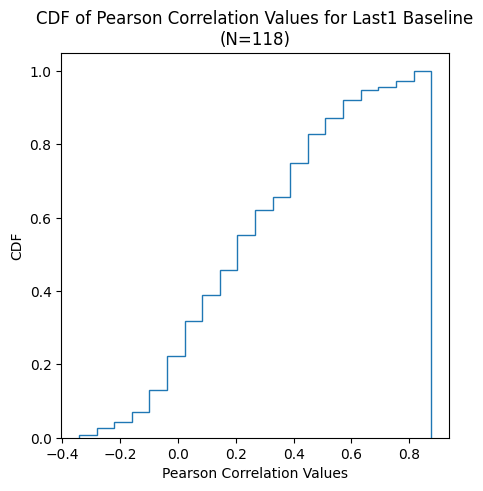

In [15]:
# Cumulative density function for the following series: [item.correlation for item in pearsonr_last1_seq]
fig, ax = plt.subplots(figsize=(5, 5))
plt.hist([item.correlation for item in pearsonr_last1_seq], bins=20, cumulative=True, density=True, histtype='step')
plt.xlabel('Pearson Correlation Values')
plt.ylabel('CDF')
plt.title('CDF of Pearson Correlation Values for Last1 Baseline\n(N={})'.format(len(pearsonr_last1_seq)))
plt.show()

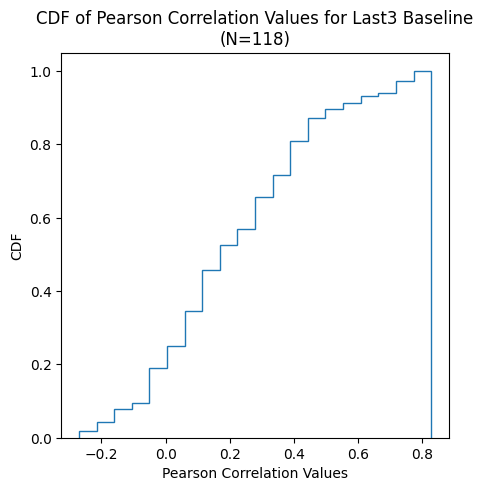

In [16]:
# Same for the last3 baseline
fig, ax = plt.subplots(figsize=(5, 5))
plt.hist([item.correlation for item in pearsonr_last3_seq], bins=20, cumulative=True, density=True, histtype='step')
plt.xlabel('Pearson Correlation Values')
plt.ylabel('CDF')
plt.title('CDF of Pearson Correlation Values for Last3 Baseline\n(N={})'.format(len(pearsonr_last3_seq)))
plt.show()

## Univariate Transformer Model Forecasting Analysis

In [42]:
import pickle
from eval import within_seq_metric
import torch

In [73]:
pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_sr_PCL/495b8cb32ffe4dd9b010033c113c5ecc/preds.pkl"
# CONFIG: trns_3lyr1hds_lr1e-2_wd5e-3_pe_1day_todayPCL_max90_do0.1_opdo_0.15
pred_dict = pickle.load(open(pred_path, 'rb'))
pred_dict.keys()

dict_keys(['train', 'val', 'test'])

In [74]:
pred_dict['val'].keys()

dict_keys(['preds', 'outcomes', 'infill_outcomes_mask', 'infill_lang_mask'])

In [93]:
# Get the predictions from the last epoch
EPOCH = -1
preds = pred_dict['val']['preds'][EPOCH]
outcomes = pred_dict['val']['outcomes'][EPOCH]
mask = pred_dict['val']['infill_outcomes_mask'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds])
for batch_idx in range(len(preds)):
    if preds[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds[batch_idx].shape[0], max_timesteps - preds[batch_idx].shape[1], preds[batch_idx].shape[2])
        preds[batch_idx] = torch.cat([preds[batch_idx], zero_pads], dim=1)
        outcomes[batch_idx] = torch.cat([outcomes[batch_idx], zero_pads], dim=1)
        mask[batch_idx] = torch.cat([mask[batch_idx], zero_pads], dim=1)
preds = torch.cat(preds, dim=0).numpy()
outcomes = torch.cat(outcomes, dim=0).numpy()
mask = torch.cat(mask, dim=0).numpy()
seq_id = range(preds.shape[0])

In [94]:
preds.shape, outcomes.shape, mask.shape

((22, 90, 1), (22, 90, 1), (22, 90, 1))

In [95]:
IDX=1
# preds[IDX][mask[IDX]==1], outcomes[IDX][mask[IDX]==1]
preds[IDX].reshape(-1, ), outcomes[IDX].reshape(-1, )

(array([1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073, 1.9135073,
        1.9135073, 1.9135073, 1.913507

In [28]:
within_seq_metrics_sr_mse = within_seq_metric("mse", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_smape = within_seq_metric("smape", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)

In [29]:
within_seq_metrics_sr_mse["mean"], within_seq_metrics_sr_smape["mean"], within_seq_metrics_sr_pearsonr["mean"]

(0.6483063515689638, 0.313558670381705, 0.019505013412526494)

In [30]:
within_seq_metrics_sr_mse["median"], within_seq_metrics_sr_smape["median"], within_seq_metrics_sr_pearsonr["median"]

(0.59713554, 0.314508855342865, 0.06366507980047643)

In [31]:
means = []
for i in range(outcomes.shape[0]):
    means.append(outcomes[i][mask[i]==1].mean())
print (sum(means)/len(means))

2.0488968392213187


## Language Based Transformer model Forecasting Analysis

In [28]:
pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead/62feef67d8a54accb77b383ba3ec3f88/preds.pkl"
# CONFIG: trns_3lyr8hds_lr3e-4_wd1e-2_pe_1day_rpca64robaL11_max90_do0.1_opdo_0.1
pred_dict = pickle.load(open(pred_path, 'rb'))

pred_dict.keys()

dict_keys(['train', 'val', 'test'])

In [29]:
# Get the predictions from the last epoch
EPOCH = -1
preds = pred_dict['val']['preds'][EPOCH]
outcomes = pred_dict['val']['outcomes'][EPOCH]
mask = pred_dict['val']['infill_outcomes_mask'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds])
for batch_idx in range(len(preds)):
    if preds[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds[batch_idx].shape[0], max_timesteps - preds[batch_idx].shape[1], preds[batch_idx].shape[2])
        preds[batch_idx] = torch.cat([preds[batch_idx], zero_pads], dim=1)
        outcomes[batch_idx] = torch.cat([outcomes[batch_idx], zero_pads], dim=1)
        mask[batch_idx] = torch.cat([mask[batch_idx], zero_pads], dim=1)
preds = torch.cat(preds, dim=0).numpy()
outcomes = torch.cat(outcomes, dim=0).numpy()
mask = torch.cat(mask, dim=0).numpy()
seq_id = range(preds.shape[0])

In [30]:
preds.shape, outcomes.shape, mask.shape

((22, 90, 1), (22, 90, 1), (22, 90, 1))

In [41]:
IDX=2
# preds[IDX][mask[IDX]==1], outcomes[IDX][mask[IDX]==1]
preds[IDX].reshape(-1, ), outcomes[IDX].reshape(-1, )

(array([3.533716  , 2.596331  , 1.8414134 , 1.6874374 , 1.9828278 ,
        2.1228154 , 1.8566581 , 2.0797765 , 1.9839393 , 1.696215  ,
        2.0236125 , 2.031986  , 1.7578269 , 1.8662194 , 1.7333511 ,
        1.7430755 , 1.6706219 , 1.7222781 , 1.99562   , 1.7595446 ,
        1.8377098 , 1.808729  , 1.740755  , 1.8948921 , 1.9082593 ,
        1.6226968 , 1.7732283 , 1.37792   , 1.4938092 , 1.572729  ,
        1.5401582 , 1.5482643 , 1.5554265 , 1.670083  , 1.6452016 ,
        1.5891438 , 1.717217  , 1.7337536 , 1.6694287 , 1.0912808 ,
        1.0491267 , 1.3208672 , 1.3278825 , 1.2736276 , 1.301498  ,
        1.324557  , 1.2066897 , 1.3234512 , 1.4259608 , 1.5038141 ,
        1.3988682 , 1.0743399 , 1.0968844 , 1.0911646 , 1.3319117 ,
        1.3801936 , 1.3481673 , 1.0275066 , 0.8294541 , 0.81588185,
        0.94972473, 1.1978372 , 1.5189346 , 1.3559071 , 1.4149032 ,
        1.3186059 , 1.4638044 , 1.3112178 , 1.2486062 , 1.1226166 ,
        1.085983  , 1.0989414 , 1.1716046 , 1.02

In [16]:
within_seq_metrics_sr_mse = within_seq_metric("mse", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_smape = within_seq_metric("smape", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)

In [17]:
within_seq_metrics_sr_mse["mean"], within_seq_metrics_sr_smape["mean"], within_seq_metrics_sr_pearsonr["mean"]

(0.8012269017371264, 0.33369048752567987, 0.05335034962629875)

In [18]:
within_seq_metrics_sr_mse["median"], within_seq_metrics_sr_smape["median"], within_seq_metrics_sr_pearsonr["median"]

(0.75560683, 0.32721443474292755, 0.027467731202179563)

In [18]:
means = []
for i in range(outcomes.shape[0]):
    means.append(outcomes[i][mask[i]==1].mean())
print (sum(means)/len(means))

2.2171019369905647


## Univariate baseline of using today's PCL as the forecast

In [19]:
from utils import add_to_path
add_to_path("/home/avirinchipur/research/LongitudeML/examples/ptsd_stop_forecasting/PCL_forecast_baselines.ipynb")

from datasets import load_from_disk
from src import get_datasetDict

import numpy as np

Adding directory to path: /home/avirinchipur/research/LongitudeML


In [20]:
data_dir = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/todayPCL_selfreport_PCL_1_days_ahead_max90days_v3_40combined_5fold/"
data = load_from_disk(data_dir)

In [21]:
datasetDict = get_datasetDict(train_data=data, val_folds=[0])
datasetDict

Filter:   0%|          | 0/118 [00:00<?, ? examples/s]

Filter:   0%|          | 0/118 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['seq_id', 'embeddings', 'num_tokens', 'time_ids', 'infill_lang_mask', 'outcomes', 'infill_outcomes_mask'],
        num_rows: 96
    })
    val: Dataset({
        features: ['seq_id', 'embeddings', 'num_tokens', 'time_ids', 'infill_lang_mask', 'outcomes', 'infill_outcomes_mask'],
        num_rows: 22
    })
})

In [22]:
preds = datasetDict['val']['embeddings']
outcomes = datasetDict['val']['outcomes']
masks = datasetDict['val']['infill_outcomes_mask']
max_timesteps = max([np.array(pred).shape[0] for pred in preds])

for idx in range(len(preds)):
    pred = np.array(preds[idx])
    outcome = np.array(outcomes[idx])
    mask = np.array(masks[idx])
    # reshape to (1, timesteps, num_outcomes) 
    pred = pred.reshape(1, pred.shape[0], pred.shape[1])
    outcome = outcome.reshape(1, outcome.shape[0], outcome.shape[1])
    mask = mask.reshape(1, mask.shape[0], mask.shape[1]) 
    if pred.shape[1] < max_timesteps:
        zero_pads = np.zeros((1, max_timesteps - pred.shape[1], pred.shape[2]))
        pred = np.concatenate([pred, zero_pads], axis=1)
        outcome = np.concatenate([outcome, zero_pads], axis=1)
        mask = np.concatenate([mask, zero_pads], axis=1)
    preds[idx] = pred
    outcomes[idx] = outcome
    masks[idx] = mask

preds = np.concatenate(preds, axis=0)
outcomes = np.concatenate(outcomes, axis=0)
masks = np.concatenate(masks, axis=0)
        

In [23]:
preds.shape, outcomes.shape, masks.shape

((22, 90, 1), (22, 90, 1), (22, 90, 1))

In [24]:
within_seq_metrics_sr_mse = within_seq_metric("mse", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=masks)
within_seq_metrics_sr_smape = within_seq_metric("smape", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=masks)
within_seq_metrics_sr_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=masks)

In [25]:
print (within_seq_metrics_sr_mse["mean"], within_seq_metrics_sr_smape["mean"], within_seq_metrics_sr_pearsonr["mean"])
print (within_seq_metrics_sr_mse["median"], within_seq_metrics_sr_smape["median"], within_seq_metrics_sr_pearsonr["median"])

0.717486195222183 0.3016922769367519 0.227537103756738
0.5735490743758036 0.25372796958184324 0.20999837285350684


In [26]:
means = []
for i in range(preds.shape[0]):
    means.append(preds[i][masks[i]==1].mean())
print (sum(means)/len(means))

2.1471421368918486


# V5 Data (reset time20 data)

## Baseline: Last PCL subscale average

In [13]:
# data_dir = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/PCLsubscales_selfreport_roberta_laL23rpca64_wtcSubscalesNormalized_merged_PCL_1_days_ahead_max60days_v6_40combined_devset_oots"
# data_dir = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/PCLsubscales_selfreport_roberta_laL23rpca64_wtcSubscalesNormalized_merged_PCL_1_days_ahead_reset_time2zero_max60days_v6_40combined_devset_oots"
data_dir = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/PCLsubscales_selfreportZ_roberta_laL23rpca64_wtcSubscalesNormalized_merged_PCL_1_days_ahead_reset_time2zero2_max60days_v6_40combined_devset_oots" # With day 0 offsetted (feat or lang present day) and z scored subscales 
data = load_from_disk(data_dir)

In [14]:
datasetDict = get_datasetDict(train_data=data, val_folds=[0])
datasetDict

Filter:   0%|          | 0/157 [00:00<?, ? examples/s]

Filter:   0%|          | 0/157 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/117 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/40 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask', 'orig_time_ids', 'oots_mask', 'embeddings_subscales_z', 'ooss_mask'],
        num_rows: 117
    })
    val: Dataset({
        features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask', 'orig_time_ids', 'oots_mask', 'embeddings_subscales_z', 'ooss_mask'],
        num_rows: 157
    })
})

In [15]:
preds = datasetDict['val']['embeddings_subscales']
outcomes = datasetDict['val']['outcomes']

In [16]:
def get_outcomes_timeseries(dataset):
    """
        Function that turns the series of outcomes into a time series df
    """
    # preds = datasetDict['val']['embeddings_subscales']
    # outcomes = datasetDict['val']['outcomes']
    # masks = datasetDict['val']['outcomes_mask']
    # max_timesteps = max([np.array(pred).shape[0] for pred in preds])
    # seq_ids = datasetDict['val']['seq_id']

    preds = dataset['embeddings_subscales']
    outcomes = dataset['outcomes']
    masks = dataset['outcomes_mask']
    max_timesteps = max([np.array(pred).shape[0] for pred in preds])
    seq_ids = dataset['seq_id']

    for idx in range(len(preds)):
        pred = np.array(preds[idx])[:, 1:].mean(-1).reshape(-1, 1)
        outcome = np.array(outcomes[idx])
        mask = np.array(masks[idx])
        # reshape to (1, timesteps, num_outcomes) 
        pred = pred.reshape(1, pred.shape[0], pred.shape[1])
        outcome = outcome.reshape(1, outcome.shape[0], outcome.shape[1])
        mask = mask.reshape(1, mask.shape[0], mask.shape[1]) 
        if pred.shape[1] < max_timesteps:
            zero_pads = np.zeros((1, max_timesteps - pred.shape[1], pred.shape[2]))
            pred = np.concatenate([pred, zero_pads], axis=1)
            outcome = np.concatenate([outcome, zero_pads], axis=1)
            mask = np.concatenate([mask, zero_pads], axis=1)
        preds[idx] = pred
        outcomes[idx] = outcome
        masks[idx] = mask

    preds = np.concatenate(preds, axis=0)
    outcomes = np.concatenate(outcomes, axis=0)
    masks = np.concatenate(masks, axis=0)

    return preds, outcomes, masks, seq_ids

In [17]:
def subset_data(datasetDict, ooss=None, oost=None):
    """
        Function that subsets the data based on the ooss and oost values
    """
    start_time = time.time()
    subset_dict = {}
    for column in datasetDict['val'].column_names:
        subset_dict[column] = []
    num_seqs = len(datasetDict['val']['seq_id'])
    if ooss is not None:
        for key in datasetDict['val'].column_names:
            for idx in range(num_seqs):
                if datasetDict['val'][idx]['ooss_mask'] == int(ooss):
                    if oost is not None and isinstance(datasetDict['val'][key][idx], list):
                        temp = []
                        for tdx, item in enumerate(datasetDict['val'][key][idx]):
                            if datasetDict['val']['oots_mask'][idx][tdx] == int(oost): temp.append(item)
                        subset_dict[key].append(temp)
                    else:    
                        subset_dict[key].append(datasetDict['val'][key][idx])
    else:
        for key in datasetDict['val'].column_names:
            for idx in range(num_seqs):
                if oost is not None and isinstance(datasetDict['val'][key][idx], list):
                    temp = []
                    for tdx, item in enumerate(datasetDict['val'][key][idx]):
                        if datasetDict['val']['oots_mask'][idx][tdx] == int(oost): temp.append(item)
                    subset_dict[key].append(temp)
                else:    
                    subset_dict[key].append(datasetDict['val'][key][idx])
    time_taken = time.time() - start_time
    print ("Subsetted the dataset for ooss={} and oost={} in {} seconds".format(ooss, oost, round(time_taken, 1)))
    return Dataset.from_dict(subset_dict)    

In [18]:
dataset_wswt = subset_data(datasetDict, ooss=0, oost=0)
dataset_wsot = subset_data(datasetDict, ooss=0, oost=1)
dataset_oswt = subset_data(datasetDict, ooss=1, oost=0)
dataset_osot = subset_data(datasetDict, ooss=1, oost=1)

Subsetted the dataset for ooss=0 and oost=0 in 384.4 seconds
Subsetted the dataset for ooss=0 and oost=1 in 382.9 seconds
Subsetted the dataset for ooss=1 and oost=0 in 133.5 seconds
Subsetted the dataset for ooss=1 and oost=1 in 133.5 seconds


In [19]:
preds, outcomes, masks, seq_ids = get_outcomes_timeseries(dataset_wswt)
wswt_mse = within_seq_metric("mse", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wswt_smape = within_seq_metric("smape", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wswt_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wswt_mae = within_seq_metric("mae", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)

preds, outcomes, masks, seq_ids = get_outcomes_timeseries(dataset_wsot)
wsot_mse = within_seq_metric("mse", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wsot_smape = within_seq_metric("smape", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wsot_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wsot_mae = within_seq_metric("mae", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)

preds, outcomes, masks, seq_ids = get_outcomes_timeseries(dataset_oswt)
oswt_mse = within_seq_metric("mse", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
oswt_smape = within_seq_metric("smape", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
oswt_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
oswt_mae = within_seq_metric("mae", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)

preds, outcomes, masks, seq_ids = get_outcomes_timeseries(dataset_osot)
osot_mse = within_seq_metric("mse", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
osot_smape = within_seq_metric("smape", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
osot_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
osot_mae = within_seq_metric("mae", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)

In [20]:
preds.shape, outcomes.shape, masks.shape

((40, 21, 1), (40, 21, 1), (40, 21, 1))

In [21]:
## Split this into 
# 1. within-sequence + within-time 
# 2. within-sequence + out-of-time 
# 3. out-of-sequence + within-time 
# 4. out-of-sequence + out-of-time 
# Also get metrics for just within-sequence and out-of-sequence, and within-time and out-of-time
ROUND_DIGITS = 4

print ("Within-Sequence + Within-Time (Mean)")
print ("MSE: ", round(wswt_mse["mean"], ROUND_DIGITS))
print ("SMAPE: ", round(wswt_smape["mean"], ROUND_DIGITS))
print ("Pearsonr: ", round(wswt_pearsonr["mean"], ROUND_DIGITS))
print ("MAE: ", round(wswt_mae["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Within-Sequence + Out-of-Time (Mean)")
print ("MSE: ", round(wsot_mse["mean"], ROUND_DIGITS))
print ("SMAPE: ", round(wsot_smape["mean"], ROUND_DIGITS))
print ("Pearsonr: ", round(wsot_pearsonr["mean"], ROUND_DIGITS))
print ("MAE: ", round(wsot_mae["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Out-of-Sequence + Within-Time (Mean)")
print ("MSE: ", round(oswt_mse["mean"], ROUND_DIGITS))
print ("SMAPE: ", round(oswt_smape["mean"], ROUND_DIGITS))
print ("Pearsonr: ", round(oswt_pearsonr["mean"], ROUND_DIGITS))
print ("MAE: ", round(oswt_mae["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Out-of-Sequence + Out-of-Time (Mean)")
print ("MSE: ", round(osot_mse["mean"], ROUND_DIGITS))
print ("SMAPE: ", round(osot_smape["mean"], ROUND_DIGITS))
print ("Pearsonr: ", round(osot_pearsonr["mean"], ROUND_DIGITS))
print ("MAE: ", round(osot_mae["mean"], ROUND_DIGITS))
print ("-----------------------------------")

Within-Sequence + Within-Time (Mean)
MSE:  0.3593
SMAPE:  0.2051
Pearsonr:  0.1904
MAE:  0.3884
-----------------------------------
Within-Sequence + Out-of-Time (Mean)
MSE:  0.3106
SMAPE:  0.1781
Pearsonr:  0.1191
MAE:  0.3384
-----------------------------------
Out-of-Sequence + Within-Time (Mean)
MSE:  0.4176
SMAPE:  0.2086
Pearsonr:  0.185
MAE:  0.4034
-----------------------------------
Out-of-Sequence + Out-of-Time (Mean)
MSE:  0.2943
SMAPE:  0.1778
Pearsonr:  0.0418
MAE:  0.3239
-----------------------------------


In [22]:
print ("SMAPE within-sequence")
print ("Within-Sequence + Within-Time (Mean): ", round(wswt_smape["mean"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(wsot_smape["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(oswt_smape["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(osot_smape["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MAE within-sequence")
print ("Within-Sequence + Within-Time (Mean): ", round(wswt_mae["mean"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(wsot_mae["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(oswt_mae["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(osot_mae["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MSE within-sequence")
print ("Within-Sequence + Within-Time (Mean): ", round(wswt_mse["mean"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(wsot_mse["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(oswt_mse["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(osot_mse["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Pearsonr within-sequence")
print ("Within-Sequence + Within-Time (Mean): ", round(wswt_pearsonr["mean"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(wsot_pearsonr["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(oswt_pearsonr["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(osot_pearsonr["mean"], ROUND_DIGITS))
print ("-----------------------------------") 


SMAPE within-sequence
Within-Sequence + Within-Time (Mean):  0.2051
Within-Sequence + Out-of-Time (Mean):  0.1781
Out-of-Sequence + Within-Time (Mean):  0.2086
Out-of-Sequence + Out-of-Time (Mean):  0.1778
-----------------------------------
MAE within-sequence
Within-Sequence + Within-Time (Mean):  0.3884
Within-Sequence + Out-of-Time (Mean):  0.3384
Out-of-Sequence + Within-Time (Mean):  0.4034
Out-of-Sequence + Out-of-Time (Mean):  0.3239
-----------------------------------
MSE within-sequence
Within-Sequence + Within-Time (Mean):  0.3593
Within-Sequence + Out-of-Time (Mean):  0.3106
Out-of-Sequence + Within-Time (Mean):  0.4176
Out-of-Sequence + Out-of-Time (Mean):  0.2943
-----------------------------------
Pearsonr within-sequence
Within-Sequence + Within-Time (Mean):  0.1904
Within-Sequence + Out-of-Time (Mean):  0.1191
Out-of-Sequence + Within-Time (Mean):  0.185
Out-of-Sequence + Out-of-Time (Mean):  0.0418
-----------------------------------


## Baseline: Rolling Mean of PCL

In [23]:
def get_rollingmean_timeseries(dataset):
    preds = dataset['embeddings_subscales']
    outcomes = dataset['outcomes']
    masks = dataset['outcomes_mask']
    preds_mask = dataset['mask_subscales']
    max_timesteps = max([np.array(pred).shape[0] for pred in preds])
    seq_ids = dataset['seq_id']

    for idx in range(len(preds)):
        pred_mean = np.array(preds[idx])[:, 1:].mean(-1).reshape(-1, 1) # The mean here takes the mean of the subscales. In v4 the subscales vector did not include the total score. 
        pred_mask = preds_mask[idx]
        # calculate the running mean of predictions. Update the mean only when the preds_mask is 0. 
        # Copy the running mean of predictions when preds_mask is 1 from the previous valid timestep
        running_mean = np.zeros(pred_mean.shape)
        running_mean[0] = pred_mean[0]
        valid_timesteps = 1 if pred_mask[0] == 0 else 0
        for i in range(1, pred_mean.shape[0]):
            running_mean[i] = running_mean[i-1] if pred_mask[i] == 1 else (running_mean[i-1]*valid_timesteps + pred_mean[i])/(valid_timesteps + 1)
            valid_timesteps += 1 if pred_mask[i] == 0 else 0
        pred = np.array(running_mean)
        pred = pred.reshape(1, pred_mean.shape[0], pred_mean.shape[1])
        outcome = np.array(outcomes[idx])
        outcome = outcome.reshape(1, outcome.shape[0], outcome.shape[1])
        mask = np.array(masks[idx])
        mask = mask.reshape(1, mask.shape[0], mask.shape[1])
        if pred.shape[1] < max_timesteps:
            zero_pads = np.zeros((1, max_timesteps - pred.shape[1], pred.shape[2]))
            pred = np.concatenate([pred, zero_pads], axis=1)
            outcome = np.concatenate([outcome, zero_pads], axis=1)
            mask = np.concatenate([mask, zero_pads], axis=1)
        preds[idx] = pred
        outcomes[idx] = outcome
        masks[idx] = mask
        
    preds = np.concatenate(preds, axis=0)
    outcomes = np.concatenate(outcomes, axis=0)
    masks = np.concatenate(masks, axis=0)
    
    return preds, outcomes, masks, seq_ids

In [24]:
preds, outcomes, masks, seq_ids = get_rollingmean_timeseries(dataset_wswt)
wswt_rmean_mse = within_seq_metric("mse", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wswt_rmean_smape = within_seq_metric("smape", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wswt_rmean_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wswt_rmean_mae = within_seq_metric("mae", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)

preds, outcomes, masks, seq_ids = get_rollingmean_timeseries(dataset_wsot)
wsot_rmean_mse = within_seq_metric("mse", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wsot_rmean_smape = within_seq_metric("smape", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wsot_rmean_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
wsot_rmean_mae = within_seq_metric("mae", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)

preds, outcomes, masks, seq_ids = get_rollingmean_timeseries(dataset_oswt)
oswt_rmean_mse = within_seq_metric("mse", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
oswt_rmean_smape = within_seq_metric("smape", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
oswt_rmean_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
oswt_rmean_mae = within_seq_metric("mae", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)

preds, outcomes, masks, seq_ids = get_rollingmean_timeseries(dataset_osot)
osot_rmean_mse = within_seq_metric("mse", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
osot_rmean_smape = within_seq_metric("smape", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
osot_rmean_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
osot_rmean_mae = within_seq_metric("mae", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)

In [25]:
print ("Within-Sequence + Within-Time (Rolling Mean)")
print ("MSE: ", round(wswt_rmean_mse["mean"], ROUND_DIGITS))
print ("SMAPE: ", round(wswt_rmean_smape["mean"], ROUND_DIGITS))
print ("Pearsonr: ", round(wswt_rmean_pearsonr["mean"], ROUND_DIGITS))
print ("MAE: ", round(wswt_rmean_mae["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Within-Sequence + Out-of-Time (Rolling Mean)")
print ("MSE: ", round(wsot_rmean_mse["mean"], ROUND_DIGITS))
print ("SMAPE: ", round(wsot_rmean_smape["mean"], ROUND_DIGITS))
print ("Pearsonr: ", round(wsot_rmean_pearsonr["mean"], ROUND_DIGITS))
print ("MAE: ", round(wsot_rmean_mae["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Out-of-Sequence + Within-Time (Rolling Mean)")
print ("MSE: ", round(oswt_rmean_mse["mean"], ROUND_DIGITS))
print ("SMAPE: ", round(oswt_rmean_smape["mean"], ROUND_DIGITS))
print ("Pearsonr: ", round(oswt_rmean_pearsonr["mean"], ROUND_DIGITS))
print ("MAE: ", round(oswt_rmean_mae["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Out-of-Sequence + Out-of-Time (Rolling Mean)")
print ("MSE: ", round(osot_rmean_mse["mean"], ROUND_DIGITS))
print ("SMAPE: ", round(osot_rmean_smape["mean"], ROUND_DIGITS))
print ("Pearsonr: ", round(osot_rmean_pearsonr["mean"], ROUND_DIGITS))
print ("MAE: ", round(osot_rmean_mae["mean"], ROUND_DIGITS))
print ("-----------------------------------")

Within-Sequence + Within-Time (Rolling Mean)
MSE:  0.2664
SMAPE:  0.1965
Pearsonr:  -0.0125
MAE:  0.3609
-----------------------------------
Within-Sequence + Out-of-Time (Rolling Mean)
MSE:  0.2432
SMAPE:  0.1709
Pearsonr:  -0.0741
MAE:  0.3161
-----------------------------------
Out-of-Sequence + Within-Time (Rolling Mean)
MSE:  0.2837
SMAPE:  0.1934
Pearsonr:  0.0561
MAE:  0.3659
-----------------------------------
Out-of-Sequence + Out-of-Time (Rolling Mean)
MSE:  0.2189
SMAPE:  0.1585
Pearsonr:  -0.0636
MAE:  0.2863
-----------------------------------


In [26]:
print ("SMAPE within-sequence (Rolling Mean)")
print ("Within-Sequence + Within-Time (Rolling Mean): ", round(wswt_rmean_smape["mean"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Rolling Mean): ", round(wsot_rmean_smape["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Rolling Mean): ", round(oswt_rmean_smape["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Rolling Mean): ", round(osot_rmean_smape["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MAE within-sequence (Rolling Mean)")
print ("Within-Sequence + Within-Time (Rolling Mean): ", round(wswt_rmean_mae["mean"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Rolling Mean): ", round(wsot_rmean_mae["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Rolling Mean): ", round(oswt_rmean_mae["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Rolling Mean): ", round(osot_rmean_mae["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MSE within-sequence (Rolling Mean)")
print ("Within-Sequence + Within-Time (Rolling Mean): ", round(wswt_rmean_mse["mean"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Rolling Mean): ", round(wsot_rmean_mse["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Rolling Mean): ", round(oswt_rmean_mse["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Rolling Mean): ", round(osot_rmean_mse["mean"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Pearsonr within-sequence (Rolling Mean)")
print ("Within-Sequence + Within-Time (Rolling Mean): ", round(wswt_rmean_pearsonr["mean"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Rolling Mean): ", round(wsot_rmean_pearsonr["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Rolling Mean): ", round(oswt_rmean_pearsonr["mean"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Rolling Mean): ", round(osot_rmean_pearsonr["mean"], ROUND_DIGITS))
print ("-----------------------------------")


SMAPE within-sequence (Rolling Mean)
Within-Sequence + Within-Time (Rolling Mean):  0.1965
Within-Sequence + Out-of-Time (Rolling Mean):  0.1709
Out-of-Sequence + Within-Time (Rolling Mean):  0.1934
Out-of-Sequence + Out-of-Time (Rolling Mean):  0.1585
-----------------------------------
MAE within-sequence (Rolling Mean)
Within-Sequence + Within-Time (Rolling Mean):  0.3609
Within-Sequence + Out-of-Time (Rolling Mean):  0.3161
Out-of-Sequence + Within-Time (Rolling Mean):  0.3659
Out-of-Sequence + Out-of-Time (Rolling Mean):  0.2863
-----------------------------------
MSE within-sequence (Rolling Mean)
Within-Sequence + Within-Time (Rolling Mean):  0.2664
Within-Sequence + Out-of-Time (Rolling Mean):  0.2432
Out-of-Sequence + Within-Time (Rolling Mean):  0.2837
Out-of-Sequence + Out-of-Time (Rolling Mean):  0.2189
-----------------------------------
Pearsonr within-sequence (Rolling Mean)
Within-Sequence + Within-Time (Rolling Mean):  -0.0125
Within-Sequence + Out-of-Time (Rolling Mea

## Ridge Model using PCL subscales 

In [6]:
#preds_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero/0552be790793497a8d72f47951c8d821/preds.pkl" #lr1e-3; wd1e-2; raw scores
preds_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero2/12c014a9ef954449af469384bf87c7d1/preds.pkl" #lr1e-3; wd1e-2; raw scores, With day 0 offsetted (feat or lang present day) and z scored subscales 
preds_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero2/126329157b354b989d3f1be8b255c645/preds.pkl" #lr1e-3; wd1e-2; raw scores, With day 0 offsetted (feat or lang present day) and z scored subscales
preds_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero2/b03c54f823bb4b3eabfc2671a7857b1f/preds.pkl" #lr1e-3; wd1e-3; raw scores, With day 0 offsetted (feat or lang present day) and z scored subscales
pred_dict = pickle.load(open(preds_path, 'rb'))
pred_dict.keys()

dict_keys(['train', 'val', 'test'])

In [7]:
# Get the predictions from the last epoch
EPOCH = -1
preds = pred_dict['val']['preds'][EPOCH]
outcomes = pred_dict['val']['outcomes'][EPOCH]
mask = pred_dict['val']['outcomes_mask'][EPOCH]
ooss_mask = pred_dict['val']['ooss_mask'][EPOCH]
oost_mask = pred_dict['val']['oots_mask'][EPOCH]
seq_id = pred_dict['val']['seq_id'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds])
for batch_idx in range(len(preds)):
    if preds[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds[batch_idx].shape[0], max_timesteps - preds[batch_idx].shape[1], preds[batch_idx].shape[2])
        preds[batch_idx] = torch.cat([preds[batch_idx], zero_pads], dim=1)
        outcomes[batch_idx] = torch.cat([outcomes[batch_idx], zero_pads], dim=1)
        mask[batch_idx] = torch.cat([mask[batch_idx], zero_pads], dim=1)
        oost_mask[batch_idx] = torch.cat([oost_mask[batch_idx], zero_pads], dim=1)
preds = torch.cat(preds, dim=0).numpy()
outcomes = torch.cat(outcomes, dim=0).numpy()
mask = torch.cat(mask, dim=0).numpy()
oost_mask = torch.cat(oost_mask, dim=0).numpy()
ooss_mask = torch.cat(ooss_mask, dim=0).numpy()
seq_id = torch.cat(seq_id, dim=0).numpy()

In [8]:
preds.shape, outcomes.shape, mask.shape, oost_mask.shape, ooss_mask.shape, seq_id.shape

((157, 60, 1), (157, 60, 1), (157, 60, 1), (157, 60), (157, 1), (157, 1))

In [9]:
def split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_ids, ooss=None, oost=None):
    if ooss is not None:
        # remove all index that have ooss_mask != ooss
        keep_idx = np.where(ooss_mask == ooss)[0]
        preds = preds[keep_idx]
        outcomes = outcomes[keep_idx]
        mask = mask[keep_idx]
        seq_ids = seq_ids[keep_idx]
        oost_mask = oost_mask[keep_idx]
    if oost is not None:
        mask &= (oost_mask == oost)[:, :, None] 
    return preds, outcomes, mask, seq_ids.reshape(-1, ).tolist()

In [10]:
pcl_subscale_ridge_within_seq_within_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=0)
pcl_subscale_ridge_within_seq_within_time_metrics["smape"] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_within_seq_within_time_metrics["mae"] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_within_seq_within_time_metrics["mse"] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_within_seq_within_time_metrics["pearsonr"] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

pcl_subscale_ridge_within_seq_out_of_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=1)
pcl_subscale_ridge_within_seq_out_of_time_metrics["smape"] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_within_seq_out_of_time_metrics["mae"] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_within_seq_out_of_time_metrics["mse"] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_within_seq_out_of_time_metrics["pearsonr"] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

pcl_subscale_ridge_out_of_seq_within_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=0)
pcl_subscale_ridge_out_of_seq_within_time_metrics["smape"] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_out_of_seq_within_time_metrics["mae"] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_out_of_seq_within_time_metrics["mse"] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_out_of_seq_within_time_metrics["pearsonr"] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

pcl_subscale_ridge_out_of_seq_out_of_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=1)
pcl_subscale_ridge_out_of_seq_out_of_time_metrics["smape"] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_out_of_seq_out_of_time_metrics["mae"] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_out_of_seq_out_of_time_metrics["mse"] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
pcl_subscale_ridge_out_of_seq_out_of_time_metrics["pearsonr"] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]



/cronus_data/conda_envs/emi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [11]:
ROUND_DIGITS=4
print ("SMAPE within-sequence (PCL Subscale Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(pcl_subscale_ridge_within_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(pcl_subscale_ridge_within_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(pcl_subscale_ridge_out_of_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(pcl_subscale_ridge_out_of_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MAE within-sequence (PCL Subscale Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(pcl_subscale_ridge_within_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(pcl_subscale_ridge_within_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(pcl_subscale_ridge_out_of_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(pcl_subscale_ridge_out_of_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MSE within-sequence (PCL Subscale Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(pcl_subscale_ridge_within_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(pcl_subscale_ridge_within_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(pcl_subscale_ridge_out_of_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(pcl_subscale_ridge_out_of_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Pearsonr within-sequence (PCL Subscale Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(pcl_subscale_ridge_within_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(pcl_subscale_ridge_within_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(pcl_subscale_ridge_out_of_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(pcl_subscale_ridge_out_of_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("-----------------------------------")


SMAPE within-sequence (PCL Subscale Ridge)
Within-Sequence + Within-Time (Mean):  0.2038
Within-Sequence + Out-of-Time (Mean):  0.1791
Out-of-Sequence + Within-Time (Mean):  0.2092
Out-of-Sequence + Out-of-Time (Mean):  0.1685
-----------------------------------
MAE within-sequence (PCL Subscale Ridge)
Within-Sequence + Within-Time (Mean):  0.3692
Within-Sequence + Out-of-Time (Mean):  0.3249
Out-of-Sequence + Within-Time (Mean):  0.3948
Out-of-Sequence + Out-of-Time (Mean):  0.3049
-----------------------------------
MSE within-sequence (PCL Subscale Ridge)
Within-Sequence + Within-Time (Mean):  0.2884
Within-Sequence + Out-of-Time (Mean):  0.2377
Out-of-Sequence + Within-Time (Mean):  0.3394
Out-of-Sequence + Out-of-Time (Mean):  0.2136
-----------------------------------
Pearsonr within-sequence (PCL Subscale Ridge)
Within-Sequence + Within-Time (Mean):  0.1225
Within-Sequence + Out-of-Time (Mean):  0.0721
Out-of-Sequence + Within-Time (Mean):  0.1245
Out-of-Sequence + Out-of-Time (

## Ridge Model using Language features 

In [24]:
# preds_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero/548a404b52434e96aaf6397a9755457c/preds.pkl" # lr1e-2; wd1e-3
preds_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero/2727fcead15943f0b1a98b8d633a2f74/preds.pkl" # lr1e-2; wd1e-3; raw scores
pred_dict = pickle.load(open(preds_path, 'rb'))
pred_dict.keys()

dict_keys(['train', 'val', 'test'])

In [28]:
len(pred_dict['val']['preds'])

101

In [39]:
# Get the predictions from the last epoch
EPOCH = 50
preds = pred_dict['val']['preds'][EPOCH]
outcomes = pred_dict['val']['outcomes'][EPOCH]
mask = pred_dict['val']['outcomes_mask'][EPOCH]
ooss_mask = pred_dict['val']['ooss_mask'][EPOCH]
oost_mask = pred_dict['val']['oots_mask'][EPOCH]
seq_id = pred_dict['val']['seq_id'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds])
for batch_idx in range(len(preds)):
    if preds[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds[batch_idx].shape[0], max_timesteps - preds[batch_idx].shape[1], preds[batch_idx].shape[2])
        preds[batch_idx] = torch.cat([preds[batch_idx], zero_pads], dim=1)
        outcomes[batch_idx] = torch.cat([outcomes[batch_idx], zero_pads], dim=1)
        mask[batch_idx] = torch.cat([mask[batch_idx], zero_pads], dim=1)
        oost_mask[batch_idx] = torch.cat([oost_mask[batch_idx], zero_pads], dim=1)
preds = torch.cat(preds, dim=0).numpy()
outcomes = torch.cat(outcomes, dim=0).numpy()
mask = torch.cat(mask, dim=0).numpy()
oost_mask = torch.cat(oost_mask, dim=0).numpy()
ooss_mask = torch.cat(ooss_mask, dim=0).numpy()
seq_id = torch.cat(seq_id, dim=0).numpy()

In [40]:
preds.shape, outcomes.shape, mask.shape, oost_mask.shape, ooss_mask.shape, seq_id.shape

((157, 60, 1), (157, 60, 1), (157, 60, 1), (157, 60), (157, 1), (157, 1))

In [41]:
def split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_ids, ooss=None, oost=None):
    if ooss is not None:
        # remove all index that have ooss_mask != ooss
        keep_idx = np.where(ooss_mask == ooss)[0]
        preds = preds[keep_idx]
        outcomes = outcomes[keep_idx]
        mask = mask[keep_idx]
        seq_ids = seq_ids[keep_idx]
        oost_mask = oost_mask[keep_idx]
    if oost is not None:
        mask &= (oost_mask == oost)[:, :, None] 
    return preds, outcomes, mask, seq_ids.reshape(-1, ).tolist()

In [42]:
## Split this into
# 1. within-sequence + within-time
lang_ridge_within_seq_within_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=0)
lang_ridge_within_seq_within_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_within_seq_within_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_within_seq_within_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_within_seq_within_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]


# 2. within-sequence + out-of-time
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=1)
lang_ridge_within_seq_out_of_time_metrics = {}
lang_ridge_within_seq_out_of_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_within_seq_out_of_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_within_seq_out_of_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_within_seq_out_of_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 3. out-of-sequence + within-time
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=0)
lang_ridge_out_of_seq_within_time_metrics = {}
lang_ridge_out_of_seq_within_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_out_of_seq_within_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_out_of_seq_within_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_out_of_seq_within_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 4. out-of-sequence + out-of-time
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=1)
lang_ridge_out_of_seq_out_of_time_metrics = {}
lang_ridge_out_of_seq_out_of_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_out_of_seq_out_of_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_out_of_seq_out_of_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_ridge_out_of_seq_out_of_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]


In [43]:
print ("SMAPE within-sequence (Lang Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(lang_ridge_within_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(lang_ridge_within_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(lang_ridge_out_of_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(lang_ridge_out_of_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MAE within-sequence (Lang Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(lang_ridge_within_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(lang_ridge_within_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(lang_ridge_out_of_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(lang_ridge_out_of_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MSE within-sequence (Lang Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(lang_ridge_within_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(lang_ridge_within_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(lang_ridge_out_of_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(lang_ridge_out_of_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Pearsonr within-sequence (Lang Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(lang_ridge_within_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(lang_ridge_within_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(lang_ridge_out_of_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(lang_ridge_out_of_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("-----------------------------------")

SMAPE within-sequence (Lang Ridge)
Within-Sequence + Within-Time (Mean):  0.3058
Within-Sequence + Out-of-Time (Mean):  0.3108
Out-of-Sequence + Within-Time (Mean):  0.3435
Out-of-Sequence + Out-of-Time (Mean):  0.3463
-----------------------------------
MAE within-sequence (Lang Ridge)
Within-Sequence + Within-Time (Mean):  0.5543
Within-Sequence + Out-of-Time (Mean):  0.5624
Out-of-Sequence + Within-Time (Mean):  0.6829
Out-of-Sequence + Out-of-Time (Mean):  0.6587
-----------------------------------
MSE within-sequence (Lang Ridge)
Within-Sequence + Within-Time (Mean):  0.5206
Within-Sequence + Out-of-Time (Mean):  0.5545
Out-of-Sequence + Within-Time (Mean):  0.9443
Out-of-Sequence + Out-of-Time (Mean):  0.9046
-----------------------------------
Pearsonr within-sequence (Lang Ridge)
Within-Sequence + Within-Time (Mean):  0.0808
Within-Sequence + Out-of-Time (Mean):  0.0651
Out-of-Sequence + Within-Time (Mean):  0.0238
Out-of-Sequence + Out-of-Time (Mean):  0.0845
-----------------

In [44]:
print ("Within-Sequence + Within-Time (Mean)")
print ("MSE: ", round(lang_ridge_within_seq_within_time_metrics['mse'], ROUND_DIGITS))
print ("SMAPE: ", round(lang_ridge_within_seq_within_time_metrics['smape'], ROUND_DIGITS))
print ("Pearsonr: ", round(lang_ridge_within_seq_within_time_metrics['pearsonr'], ROUND_DIGITS))
print ("MAE: ", round(lang_ridge_within_seq_within_time_metrics['mae'], ROUND_DIGITS))
print ("-----------------------------------")

print ("Within-Sequence + Out-of-Time (Mean)")
print ("MSE: ", round(lang_ridge_within_seq_out_of_time_metrics['mse'], ROUND_DIGITS))
print ("SMAPE: ", round(lang_ridge_within_seq_out_of_time_metrics['smape'], ROUND_DIGITS))
print ("Pearsonr: ", round(lang_ridge_within_seq_out_of_time_metrics['pearsonr'], ROUND_DIGITS))
print ("MAE: ", round(lang_ridge_within_seq_out_of_time_metrics['mae'], ROUND_DIGITS))
print ("-----------------------------------")

print ("Out-of-Sequence + Within-Time (Mean)")
print ("MSE: ", round(lang_ridge_out_of_seq_within_time_metrics['mse'], ROUND_DIGITS))
print ("SMAPE: ", round(lang_ridge_out_of_seq_within_time_metrics['smape'], ROUND_DIGITS))
print ("Pearsonr: ", round(lang_ridge_out_of_seq_within_time_metrics['pearsonr'], ROUND_DIGITS))
print ("MAE: ", round(lang_ridge_out_of_seq_within_time_metrics['mae'], ROUND_DIGITS))
print ("-----------------------------------")

print ("Out-of-Sequence + Out-of-Time (Mean)")
print ("MSE: ", round(lang_ridge_out_of_seq_out_of_time_metrics['mse'], ROUND_DIGITS))
print ("SMAPE: ", round(lang_ridge_out_of_seq_out_of_time_metrics['smape'], ROUND_DIGITS))
print ("Pearsonr: ", round(lang_ridge_out_of_seq_out_of_time_metrics['pearsonr'], ROUND_DIGITS))
print ("MAE: ", round(lang_ridge_out_of_seq_out_of_time_metrics['mae'], ROUND_DIGITS))
print ("-----------------------------------")

Within-Sequence + Within-Time (Mean)
MSE:  0.5206
SMAPE:  0.3058
Pearsonr:  0.0808
MAE:  0.5543
-----------------------------------
Within-Sequence + Out-of-Time (Mean)
MSE:  0.5545
SMAPE:  0.3108
Pearsonr:  0.0651
MAE:  0.5624
-----------------------------------
Out-of-Sequence + Within-Time (Mean)
MSE:  0.9443
SMAPE:  0.3435
Pearsonr:  0.0238
MAE:  0.6829
-----------------------------------
Out-of-Sequence + Out-of-Time (Mean)
MSE:  0.9046
SMAPE:  0.3463
Pearsonr:  0.0845
MAE:  0.6587
-----------------------------------


In [33]:
## Ridge Model using PCL, SS, Language 

In [34]:
pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero2/04813bed3d88437f9cef2d096ab83b70/preds.pkl"
pred_dict = pickle.load(open(pred_path, 'rb'))
pred_dict.keys()

dict_keys(['train', 'val', 'test'])

In [44]:
# Get the predictions from the last epoch
EPOCH = -1
preds = pred_dict['val']['preds'][EPOCH]
outcomes = pred_dict['val']['outcomes'][EPOCH]
mask = pred_dict['val']['outcomes_mask'][EPOCH]
ooss_mask = pred_dict['val']['ooss_mask'][EPOCH]
oost_mask = pred_dict['val']['oots_mask'][EPOCH]
seq_id = pred_dict['val']['seq_id'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds])
for batch_idx in range(len(preds)):
    if preds[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds[batch_idx].shape[0], max_timesteps - preds[batch_idx].shape[1], preds[batch_idx].shape[2])
        preds[batch_idx] = torch.cat([preds[batch_idx], zero_pads], dim=1)
        outcomes[batch_idx] = torch.cat([outcomes[batch_idx], zero_pads], dim=1)
        mask[batch_idx] = torch.cat([mask[batch_idx], zero_pads], dim=1)
        oost_mask[batch_idx] = torch.cat([oost_mask[batch_idx], zero_pads], dim=1)
preds = torch.cat(preds, dim=0).numpy()
outcomes = torch.cat(outcomes, dim=0).numpy()
mask = torch.cat(mask, dim=0).numpy()
oost_mask = torch.cat(oost_mask, dim=0).numpy()
ooss_mask = torch.cat(ooss_mask, dim=0).numpy()
seq_id = torch.cat(seq_id, dim=0).numpy()

In [45]:
## Split this into
# 1. within-sequence + within-time
subscaleslang_ridge_within_seq_within_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=0)
subscaleslang_ridge_within_seq_within_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_within_seq_within_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_within_seq_within_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_within_seq_within_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 2. within-sequence + out-of-time
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=1)
subscaleslang_ridge_within_seq_out_of_time_metrics = {}
subscaleslang_ridge_within_seq_out_of_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_within_seq_out_of_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_within_seq_out_of_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_within_seq_out_of_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 3. out-of-sequence + within-time
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=0)
subscaleslang_ridge_out_of_seq_within_time_metrics = {}
subscaleslang_ridge_out_of_seq_within_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_out_of_seq_within_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_out_of_seq_within_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_out_of_seq_within_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 4. out-of-sequence + out-of-time
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=1)
subscaleslang_ridge_out_of_seq_out_of_time_metrics = {}
subscaleslang_ridge_out_of_seq_out_of_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_out_of_seq_out_of_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_out_of_seq_out_of_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscaleslang_ridge_out_of_seq_out_of_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]



In [46]:
ROUND_DIGITS = 4
print ("SMAPE within-sequence (Subscales Lang Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(subscaleslang_ridge_within_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(subscaleslang_ridge_within_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(subscaleslang_ridge_out_of_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(subscaleslang_ridge_out_of_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MAE within-sequence (Subscales Lang Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(subscaleslang_ridge_within_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(subscaleslang_ridge_within_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(subscaleslang_ridge_out_of_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(subscaleslang_ridge_out_of_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MSE within-sequence (Subscales Lang Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(subscaleslang_ridge_within_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(subscaleslang_ridge_within_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(subscaleslang_ridge_out_of_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(subscaleslang_ridge_out_of_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Pearsonr within-sequence (Subscales Lang Ridge)")
print ("Within-Sequence + Within-Time (Mean): ", round(subscaleslang_ridge_within_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(subscaleslang_ridge_within_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(subscaleslang_ridge_out_of_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(subscaleslang_ridge_out_of_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("-----------------------------------")

SMAPE within-sequence (Subscales Lang Ridge)
Within-Sequence + Within-Time (Mean):  0.2187
Within-Sequence + Out-of-Time (Mean):  0.2037
Out-of-Sequence + Within-Time (Mean):  0.2338
Out-of-Sequence + Out-of-Time (Mean):  0.2137
-----------------------------------
MAE within-sequence (Subscales Lang Ridge)
Within-Sequence + Within-Time (Mean):  0.3995
Within-Sequence + Out-of-Time (Mean):  0.3692
Out-of-Sequence + Within-Time (Mean):  0.4448
Out-of-Sequence + Out-of-Time (Mean):  0.3897
-----------------------------------
MSE within-sequence (Subscales Lang Ridge)
Within-Sequence + Within-Time (Mean):  0.3274
Within-Sequence + Out-of-Time (Mean):  0.2929
Out-of-Sequence + Within-Time (Mean):  0.4033
Out-of-Sequence + Out-of-Time (Mean):  0.3062
-----------------------------------
Pearsonr within-sequence (Subscales Lang Ridge)
Within-Sequence + Within-Time (Mean):  0.1834
Within-Sequence + Out-of-Time (Mean):  0.0997
Out-of-Sequence + Within-Time (Mean):  0.1535
Out-of-Sequence + Out-o

## Transformer Model using PCL subscales  

In [12]:
# pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5/a1613313f876416bb6455144ab5188b8/preds.pkl"
pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero/9fbac14a066648e48f7851c9fbd8a306/preds.pkl" #lr 1e-2; wd 1e-3; do0.01; odo 0.1; raw scores
# pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero_trial/1e805b29ce07401ca4129028e29eb099/preds.pkl"
pred_dict = pickle.load(open(pred_path, 'rb'))
pred_dict.keys()

dict_keys(['train', 'val', 'test'])

In [13]:
# Get the predictions from the last epoch
EPOCH = -1
preds = pred_dict['val']['preds'][EPOCH]
outcomes = pred_dict['val']['outcomes'][EPOCH]
mask = pred_dict['val']['outcomes_mask'][EPOCH]
ooss_mask = pred_dict['val']['ooss_mask'][EPOCH]
oost_mask = pred_dict['val']['oots_mask'][EPOCH]
seq_id = pred_dict['val']['seq_id'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds])
for batch_idx in range(len(preds)):
    if preds[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds[batch_idx].shape[0], max_timesteps - preds[batch_idx].shape[1], preds[batch_idx].shape[2])
        preds[batch_idx] = torch.cat([preds[batch_idx], zero_pads], dim=1)
        outcomes[batch_idx] = torch.cat([outcomes[batch_idx], zero_pads], dim=1)
        mask[batch_idx] = torch.cat([mask[batch_idx], zero_pads], dim=1)
        oost_mask[batch_idx] = torch.cat([oost_mask[batch_idx], zero_pads], dim=1)
preds = torch.cat(preds, dim=0).numpy()
outcomes = torch.cat(outcomes, dim=0).numpy()
mask = torch.cat(mask, dim=0).numpy()
oost_mask = torch.cat(oost_mask, dim=0).numpy()
ooss_mask = torch.cat(ooss_mask, dim=0).numpy()
seq_id = torch.cat(seq_id, dim=0).numpy()

In [14]:
def split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_ids, ooss=None, oost=None):
    if ooss is not None:
        # remove all index that have ooss_mask != ooss
        keep_idx = np.where(ooss_mask == ooss)[0]
        preds = preds[keep_idx]
        outcomes = outcomes[keep_idx]
        mask = mask[keep_idx]
        seq_ids = seq_ids[keep_idx]
        oost_mask = oost_mask[keep_idx]
    if oost is not None:
        mask &= (oost_mask == oost)[:, :, None] 
    return preds, outcomes, mask, seq_ids.reshape(-1, ).tolist()

In [15]:
## Split this into
# 1. within-sequence + within-time
subscales_trns_within_seq_within_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=0)
subscales_trns_within_seq_within_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_within_seq_within_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_within_seq_within_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_within_seq_within_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 2. within-sequence + out-of-time
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=1)
subscales_trns_within_seq_out_of_time_metrics = {}
subscales_trns_within_seq_out_of_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_within_seq_out_of_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_within_seq_out_of_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_within_seq_out_of_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 3. out-of-sequence + within-time
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=0)
subscales_trns_out_of_seq_within_time_metrics = {}
subscales_trns_out_of_seq_within_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_out_of_seq_within_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_out_of_seq_within_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_out_of_seq_within_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 4. out-of-sequence + out-of-time
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=1)
subscales_trns_out_of_seq_out_of_time_metrics = {}
subscales_trns_out_of_seq_out_of_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_out_of_seq_out_of_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_out_of_seq_out_of_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
subscales_trns_out_of_seq_out_of_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]



/cronus_data/conda_envs/emi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [16]:
ROUND_DIGITS = 4
print ("SMAPE within-sequence (Subscales TRNS)")
print ("Within-Sequence + Within-Time (Mean): ", round(subscales_trns_within_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(subscales_trns_within_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(subscales_trns_out_of_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(subscales_trns_out_of_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MAE within-sequence (Subscales TRNS)")
print ("Within-Sequence + Within-Time (Mean): ", round(subscales_trns_within_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(subscales_trns_within_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(subscales_trns_out_of_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(subscales_trns_out_of_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MSE within-sequence (Subscales TRNS)")
print ("Within-Sequence + Within-Time (Mean): ", round(subscales_trns_within_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(subscales_trns_within_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(subscales_trns_out_of_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(subscales_trns_out_of_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Pearsonr within-sequence (Subscales TRNS)")
print ("Within-Sequence + Within-Time (Mean): ", round(subscales_trns_within_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(subscales_trns_within_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(subscales_trns_out_of_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(subscales_trns_out_of_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("-----------------------------------")

SMAPE within-sequence (Subscales TRNS)
Within-Sequence + Within-Time (Mean):  0.2002
Within-Sequence + Out-of-Time (Mean):  0.1846
Out-of-Sequence + Within-Time (Mean):  0.2095
Out-of-Sequence + Out-of-Time (Mean):  0.1829
-----------------------------------
MAE within-sequence (Subscales TRNS)
Within-Sequence + Within-Time (Mean):  0.372
Within-Sequence + Out-of-Time (Mean):  0.3439
Out-of-Sequence + Within-Time (Mean):  0.4267
Out-of-Sequence + Out-of-Time (Mean):  0.3612
-----------------------------------
MSE within-sequence (Subscales TRNS)
Within-Sequence + Within-Time (Mean):  0.2925
Within-Sequence + Out-of-Time (Mean):  0.2682
Out-of-Sequence + Within-Time (Mean):  0.4077
Out-of-Sequence + Out-of-Time (Mean):  0.303
-----------------------------------
Pearsonr within-sequence (Subscales TRNS)
Within-Sequence + Within-Time (Mean):  0.16
Within-Sequence + Out-of-Time (Mean):  0.0625
Out-of-Sequence + Within-Time (Mean):  0.1355
Out-of-Sequence + Out-of-Time (Mean):  0.0262
-----

## Transformer Model using Language  

In [46]:
# pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5/a1613313f876416bb6455144ab5188b8/preds.pkl"
pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero/4ce9cbc923f2449589ac03b872f7eeb7/preds.pkl" #lr 1e-3; wd 1e-1; do0.15; odo 0.15; raw scores
pred_dict = pickle.load(open(pred_path, 'rb'))
pred_dict.keys()

dict_keys(['train', 'val', 'test'])

In [47]:
pred_dict['val'].keys()

dict_keys(['preds', 'outcomes', 'outcomes_mask', 'infill_lang_mask', 'seq_id', 'time_ids', 'oots_mask', 'ooss_mask'])

In [48]:
(pred_dict['val']['preds'][-1][3]).shape

torch.Size([32, 60, 1])

In [52]:
# Get the predictions from the last epoch
EPOCH = -1
preds = pred_dict['val']['preds'][EPOCH]
outcomes = pred_dict['val']['outcomes'][EPOCH]
mask = pred_dict['val']['outcomes_mask'][EPOCH]
ooss_mask = pred_dict['val']['ooss_mask'][EPOCH]
oost_mask = pred_dict['val']['oots_mask'][EPOCH]
seq_id = pred_dict['val']['seq_id'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds])
for batch_idx in range(len(preds)):
    if preds[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds[batch_idx].shape[0], max_timesteps - preds[batch_idx].shape[1], preds[batch_idx].shape[2])
        preds[batch_idx] = torch.cat([preds[batch_idx], zero_pads], dim=1)
        outcomes[batch_idx] = torch.cat([outcomes[batch_idx], zero_pads], dim=1)
        mask[batch_idx] = torch.cat([mask[batch_idx], zero_pads], dim=1)
        oost_mask[batch_idx] = torch.cat([oost_mask[batch_idx], zero_pads], dim=1)
preds = torch.cat(preds, dim=0).numpy()
outcomes = torch.cat(outcomes, dim=0).numpy()
mask = torch.cat(mask, dim=0).numpy()
oost_mask = torch.cat(oost_mask, dim=0).numpy()
ooss_mask = torch.cat(ooss_mask, dim=0).numpy()
seq_id = torch.cat(seq_id, dim=0).numpy()

In [53]:
def split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_ids, ooss=None, oost=None):
    if ooss is not None:
        # remove all index that have ooss_mask != ooss
        keep_idx = np.where(ooss_mask == ooss)[0]
        preds = preds[keep_idx]
        outcomes = outcomes[keep_idx]
        mask = mask[keep_idx]
        seq_ids = seq_ids[keep_idx]
        oost_mask = oost_mask[keep_idx]
    if oost is not None:
        mask &= (oost_mask == oost)[:, :, None] 
    return preds, outcomes, mask, seq_ids.reshape(-1, ).tolist()

In [54]:
## Split this into
# 1. within-sequence + within-time
lang_trns_within_seq_within_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=0)
lang_trns_within_seq_within_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_within_seq_within_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_within_seq_within_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_within_seq_within_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 2. within-sequence + out-of-time
lang_trns_within_seq_out_of_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=1)
lang_trns_within_seq_out_of_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_within_seq_out_of_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_within_seq_out_of_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_within_seq_out_of_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 3. out-of-sequence + within-time
lang_trns_out_of_seq_within_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=0)
lang_trns_out_of_seq_within_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_out_of_seq_within_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_out_of_seq_within_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_out_of_seq_within_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 4. out-of-sequence + out-of-time
lang_trns_out_of_seq_out_of_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=1)
lang_trns_out_of_seq_out_of_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_out_of_seq_out_of_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_out_of_seq_out_of_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
lang_trns_out_of_seq_out_of_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

/cronus_data/conda_envs/emi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [55]:
print ("SMAPE within-sequence (Lang Transformer)")
print ("Within-Sequence + Within-Time (Mean): ", round(lang_trns_within_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(lang_trns_within_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(lang_trns_out_of_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(lang_trns_out_of_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MAE within-sequence (Lang Transformer)")
print ("Within-Sequence + Within-Time (Mean): ", round(lang_trns_within_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(lang_trns_within_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(lang_trns_out_of_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(lang_trns_out_of_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MSE within-sequence (Lang Transformer)")
print ("Within-Sequence + Within-Time (Mean): ", round(lang_trns_within_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(lang_trns_within_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(lang_trns_out_of_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(lang_trns_out_of_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Pearsonr within-sequence (Lang Transformer)")
print ("Within-Sequence + Within-Time (Mean): ", round(lang_trns_within_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(lang_trns_within_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(lang_trns_out_of_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(lang_trns_out_of_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("-----------------------------------")

SMAPE within-sequence (Lang Transformer)
Within-Sequence + Within-Time (Mean):  0.2502
Within-Sequence + Out-of-Time (Mean):  0.2644
Out-of-Sequence + Within-Time (Mean):  0.3275
Out-of-Sequence + Out-of-Time (Mean):  0.3108
-----------------------------------
MAE within-sequence (Lang Transformer)
Within-Sequence + Within-Time (Mean):  0.4549
Within-Sequence + Out-of-Time (Mean):  0.4812
Out-of-Sequence + Within-Time (Mean):  0.6592
Out-of-Sequence + Out-of-Time (Mean):  0.6132
-----------------------------------
MSE within-sequence (Lang Transformer)
Within-Sequence + Within-Time (Mean):  0.3739
Within-Sequence + Out-of-Time (Mean):  0.4258
Out-of-Sequence + Within-Time (Mean):  0.906
Out-of-Sequence + Out-of-Time (Mean):  0.8323
-----------------------------------
Pearsonr within-sequence (Lang Transformer)
Within-Sequence + Within-Time (Mean):  0.1495
Within-Sequence + Out-of-Time (Mean):  0.066
Out-of-Sequence + Within-Time (Mean):  -0.0019
Out-of-Sequence + Out-of-Time (Mean):  0

## Avg - Transformer Model using Language + Transformer Model using PCL subscales  

In [62]:
preds1_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero/4ce9cbc923f2449589ac03b872f7eeb7/preds.pkl" #lr 1e-3; wd 1e-1; do0.15; odo 0.15; raw scores
preds2_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_PCL_v5_reset2zero/9fbac14a066648e48f7851c9fbd8a306/preds.pkl" #lr 1e-2; wd 1e-3; do0.01; odo 0.1; raw scores
pred1_dict = pickle.load(open(preds1_path, 'rb'))
pred2_dict = pickle.load(open(preds2_path, 'rb'))

In [63]:
EPOCH = -1
preds1 = pred1_dict['val']['preds'][EPOCH]
outcomes1 = pred1_dict['val']['outcomes'][EPOCH]
mask1 = pred1_dict['val']['outcomes_mask'][EPOCH]
ooss_mask1 = pred1_dict['val']['ooss_mask'][EPOCH]
oost_mask1 = pred1_dict['val']['oots_mask'][EPOCH]
seq_id1 = pred1_dict['val']['seq_id'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds1])
for batch_idx in range(len(preds1)):
    if preds1[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds1[batch_idx].shape[0], max_timesteps - preds1[batch_idx].shape[1], preds1[batch_idx].shape[2])
        preds1[batch_idx] = torch.cat([preds1[batch_idx], zero_pads], dim=1)
        outcomes1[batch_idx] = torch.cat([outcomes1[batch_idx], zero_pads], dim=1)
        mask1[batch_idx] = torch.cat([mask1[batch_idx], zero_pads], dim=1)
        oost_mask1[batch_idx] = torch.cat([oost_mask1[batch_idx], zero_pads], dim=1)
preds1 = torch.cat(preds1, dim=0).numpy()
outcomes1 = torch.cat(outcomes1, dim=0).numpy()
mask1 = torch.cat(mask1, dim=0).numpy()
oost_mask1 = torch.cat(oost_mask1, dim=0).numpy()
ooss_mask1 = torch.cat(ooss_mask1, dim=0).numpy()
seq_id1 = torch.cat(seq_id1, dim=0).numpy()

In [64]:
EPOCH = -1
preds2 = pred2_dict['val']['preds'][EPOCH]
outcomes2 = pred2_dict['val']['outcomes'][EPOCH]
mask2 = pred2_dict['val']['outcomes_mask'][EPOCH]
ooss_mask2 = pred2_dict['val']['ooss_mask'][EPOCH]
oost_mask2 = pred2_dict['val']['oots_mask'][EPOCH]
seq_id2 = pred2_dict['val']['seq_id'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds2])
for batch_idx in range(len(preds2)):
    if preds2[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds2[batch_idx].shape[0], max_timesteps - preds2[batch_idx].shape[1], preds2[batch_idx].shape[2])
        preds2[batch_idx] = torch.cat([preds2[batch_idx], zero_pads], dim=1)
        outcomes2[batch_idx] = torch.cat([outcomes2[batch_idx], zero_pads], dim=1)
        mask2[batch_idx] = torch.cat([mask2[batch_idx], zero_pads], dim=1)
        oost_mask2[batch_idx] = torch.cat([oost_mask2[batch_idx], zero_pads], dim=1)
preds2 = torch.cat(preds2, dim=0).numpy()
outcomes2 = torch.cat(outcomes2, dim=0).numpy()
mask2 = torch.cat(mask2, dim=0).numpy()
oost_mask2 = torch.cat(oost_mask2, dim=0).numpy()
ooss_mask2 = torch.cat(ooss_mask2, dim=0).numpy()
seq_id2 = torch.cat(seq_id2, dim=0).numpy()

In [69]:
(seq_id1 != seq_id2).sum(), (outcomes1 != outcomes2).sum(), (mask1 != mask2).sum(), (oost_mask1 != oost_mask2).sum(), (ooss_mask1 != ooss_mask2).sum()

(0, 0, 0, 0, 0)

In [70]:
preds = (preds1 + preds2) / 2
outcomes = outcomes1
mask = mask1
oost_mask = oost_mask1
ooss_mask = ooss_mask1
seq_id = seq_id1


In [71]:
## Split this into
# 1. within-sequence + within-time
avg_lang_trns_ss_trns_within_seq_within_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=0)
avg_lang_trns_ss_trns_within_seq_within_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_within_seq_within_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_within_seq_within_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_within_seq_within_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 2. within-sequence + out-of-time
avg_lang_trns_ss_trns_within_seq_out_of_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=0, oost=1)
avg_lang_trns_ss_trns_within_seq_out_of_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_within_seq_out_of_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_within_seq_out_of_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_within_seq_out_of_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 3. out-of-sequence + within-time
avg_lang_trns_ss_trns_out_of_seq_within_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=0)
avg_lang_trns_ss_trns_out_of_seq_within_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_out_of_seq_within_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_out_of_seq_within_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_out_of_seq_within_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

# 4. out-of-sequence + out-of-time
avg_lang_trns_ss_trns_out_of_seq_out_of_time_metrics = {}
preds_, outcomes_, mask_, seq_id_ = split_data(preds, outcomes, mask, oost_mask, ooss_mask, seq_id, ooss=1, oost=1)
avg_lang_trns_ss_trns_out_of_seq_out_of_time_metrics['mse'] = within_seq_metric("mse", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_out_of_seq_out_of_time_metrics['smape'] = within_seq_metric("smape", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_out_of_seq_out_of_time_metrics['pearsonr'] = within_seq_metric("pearsonr", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]
avg_lang_trns_ss_trns_out_of_seq_out_of_time_metrics['mae'] = within_seq_metric("mae", seq_ids=seq_id_, preds=preds_, labels=outcomes_, outcome_masks=mask_)["mean"]

/cronus_data/conda_envs/emi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [72]:
print ("SMAPE within-sequence (Avg Lang Transformer + Subscales Transformer)")
print ("Within-Sequence + Within-Time (Mean): ", round(avg_lang_trns_ss_trns_within_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(avg_lang_trns_ss_trns_within_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(avg_lang_trns_ss_trns_out_of_seq_within_time_metrics["smape"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(avg_lang_trns_ss_trns_out_of_seq_out_of_time_metrics["smape"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MAE within-sequence (Avg Lang Transformer + Subscales Transformer)")
print ("Within-Sequence + Within-Time (Mean): ", round(avg_lang_trns_ss_trns_within_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(avg_lang_trns_ss_trns_within_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(avg_lang_trns_ss_trns_out_of_seq_within_time_metrics["mae"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(avg_lang_trns_ss_trns_out_of_seq_out_of_time_metrics["mae"], ROUND_DIGITS))
print ("-----------------------------------")

print ("MSE within-sequence (Avg Lang Transformer + Subscales Transformer)")
print ("Within-Sequence + Within-Time (Mean): ", round(avg_lang_trns_ss_trns_within_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(avg_lang_trns_ss_trns_within_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(avg_lang_trns_ss_trns_out_of_seq_within_time_metrics["mse"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(avg_lang_trns_ss_trns_out_of_seq_out_of_time_metrics["mse"], ROUND_DIGITS))
print ("-----------------------------------")

print ("Pearsonr within-sequence (Avg Lang Transformer + Subscales Transformer)")
print ("Within-Sequence + Within-Time (Mean): ", round(avg_lang_trns_ss_trns_within_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Within-Sequence + Out-of-Time (Mean): ", round(avg_lang_trns_ss_trns_within_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Within-Time (Mean): ", round(avg_lang_trns_ss_trns_out_of_seq_within_time_metrics["pearsonr"], ROUND_DIGITS))
print ("Out-of-Sequence + Out-of-Time (Mean): ", round(avg_lang_trns_ss_trns_out_of_seq_out_of_time_metrics["pearsonr"], ROUND_DIGITS))
print ("-----------------------------------")


SMAPE within-sequence (Avg Lang Transformer + Subscales Transformer)
Within-Sequence + Within-Time (Mean):  0.2146
Within-Sequence + Out-of-Time (Mean):  0.2121
Out-of-Sequence + Within-Time (Mean):  0.2505
Out-of-Sequence + Out-of-Time (Mean):  0.225
-----------------------------------
MAE within-sequence (Avg Lang Transformer + Subscales Transformer)
Within-Sequence + Within-Time (Mean):  0.3946
Within-Sequence + Out-of-Time (Mean):  0.3888
Out-of-Sequence + Within-Time (Mean):  0.5084
Out-of-Sequence + Out-of-Time (Mean):  0.4471
-----------------------------------
MSE within-sequence (Avg Lang Transformer + Subscales Transformer)
Within-Sequence + Within-Time (Mean):  0.3008
Within-Sequence + Out-of-Time (Mean):  0.3074
Out-of-Sequence + Within-Time (Mean):  0.5655
Out-of-Sequence + Out-of-Time (Mean):  0.4745
-----------------------------------
Pearsonr within-sequence (Avg Lang Transformer + Subscales Transformer)
Within-Sequence + Within-Time (Mean):  0.1916
Within-Sequence + Ou

# V4 data

## Univariate baseline of using today's PCL as the forecast: V4

In [4]:
# data_dir = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/PCLsubscales_selfreport_noNULLs_roberta_base_L11_rpca64_merged_PCL_1_days_ahead_max90days_v4_40combined_5fold"
data_dir = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/PCLsubscales_selfreport_noNULLs_roberta_base_L11_rpca64_hypLexNormalized_wtcSubscalesNormalized_merged_PCL_1_days_ahead_max60days_v4_40combined_5fold"
data = load_from_disk(data_dir)

In [5]:
datasetDict = get_datasetDict(train_data=data, val_folds=[0])
datasetDict

Filter:   0%|          | 0/174 [00:00<?, ? examples/s]

Filter:   0%|          | 0/174 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_hypLex', 'mask_hypLex', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask'],
        num_rows: 139
    })
    val: Dataset({
        features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_hypLex', 'mask_hypLex', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask'],
        num_rows: 35
    })
})

In [6]:
preds = datasetDict['val']['embeddings_subscales']
outcomes = datasetDict['val']['outcomes']

In [11]:
preds = datasetDict['val']['embeddings_subscales']
outcomes = datasetDict['val']['outcomes']
masks = datasetDict['val']['outcomes_mask']
max_timesteps = max([np.array(pred).shape[0] for pred in preds])
seq_ids = datasetDict['val']['seq_id']

for idx in range(len(preds)):
    pred = np.array(preds[idx]).mean(-1).reshape(-1, 1)*4 + 1
    outcome = np.array(outcomes[idx])
    mask = np.array(masks[idx])
    # reshape to (1, timesteps, num_outcomes) 
    pred = pred.reshape(1, pred.shape[0], pred.shape[1])
    outcome = outcome.reshape(1, outcome.shape[0], outcome.shape[1])
    mask = mask.reshape(1, mask.shape[0], mask.shape[1]) 
    if pred.shape[1] < max_timesteps:
        zero_pads = np.zeros((1, max_timesteps - pred.shape[1], pred.shape[2]))
        pred = np.concatenate([pred, zero_pads], axis=1)
        outcome = np.concatenate([outcome, zero_pads], axis=1)
        mask = np.concatenate([mask, zero_pads], axis=1)
    preds[idx] = pred
    outcomes[idx] = outcome
    masks[idx] = mask

preds = np.concatenate(preds, axis=0)
outcomes = np.concatenate(outcomes, axis=0)
masks = np.concatenate(masks, axis=0)
        

In [12]:
preds.shape, outcomes.shape, masks.shape

((35, 60, 1), (35, 60, 1), (35, 60, 1))

In [13]:
within_seq_metrics_sr_mse = within_seq_metric("mse", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
within_seq_metrics_sr_smape = within_seq_metric("smape", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
within_seq_metrics_sr_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
within_seq_metrics_sr_mae = within_seq_metric("mae", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)

In [14]:
# Print the mean metric values line by line upto 3 points of decimal
print ("Fold 0 Baseline Metrics - Last 1 as prediction")
print ("-----------------------------------------------")
print ("Within Person MSE: ", round(within_seq_metrics_sr_mse["mean"], 3))
print ("Within Person MAE: ", round(within_seq_metrics_sr_mae["mean"], 3))
print ("Within Person SMAPE: ", round(within_seq_metrics_sr_smape["mean"], 3))
print ("Within Person Pearsonr: ", round(within_seq_metrics_sr_pearsonr["mean"], 3))


Fold 0 Baseline Metrics - Last 1 as prediction
-----------------------------------------------
Within Person MSE:  0.466
Within Person MAE:  0.439
Within Person SMAPE:  0.303
Within Person Pearsonr:  0.286


In [92]:
means = []
for i in range(preds.shape[0]):
    means.append(preds[i][masks[i]==1].mean())
print (sum(means)/len(means))

1.813781367841284


## Univariate baseline of using Mean until today's PCL as the forecast: V4

In [93]:
preds = datasetDict['val']['embeddings_subscales']
outcomes = datasetDict['val']['outcomes']
masks = datasetDict['val']['outcomes_mask']
preds_mask = datasetDict['val']['mask_subscales']
max_timesteps = max([np.array(pred).shape[0] for pred in preds])
seq_ids = datasetDict['val']['seq_id']

for idx in range(len(preds)):
    pred_mean = np.array(preds[idx]).mean(-1).reshape(-1, 1) # The mean here takes the mean of the subscales. In v4 the subscales vector did not include the total score. 
    pred_mask = preds_mask[idx]
    # calculate the running mean of predictions. Update the mean only when the preds_mask is 0. 
    # Copy the running mean of predictions when preds_mask is 1 from the previous valid timestep
    running_mean = np.zeros(pred_mean.shape)
    running_mean[0] = pred_mean[0]
    valid_timesteps = 1 if pred_mask[0] == 0 else 0
    for i in range(1, pred_mean.shape[0]):
        running_mean[i] = running_mean[i-1] if pred_mask[i] == 1 else (running_mean[i-1]*valid_timesteps + pred_mean[i])/(valid_timesteps + 1)
        valid_timesteps += 1 if pred_mask[i] == 0 else 0
    pred = np.array(running_mean)
    pred = pred.reshape(1, pred_mean.shape[0], pred_mean.shape[1])
    outcome = np.array(outcomes[idx])
    outcome = outcome.reshape(1, outcome.shape[0], outcome.shape[1])
    mask = np.array(masks[idx])
    mask = mask.reshape(1, mask.shape[0], mask.shape[1])
    if pred.shape[1] < max_timesteps:
        zero_pads = np.zeros((1, max_timesteps - pred.shape[1], pred.shape[2]))
        pred = np.concatenate([pred, zero_pads], axis=1)
        outcome = np.concatenate([outcome, zero_pads], axis=1)
        mask = np.concatenate([mask, zero_pads], axis=1)
    preds[idx] = pred
    outcomes[idx] = outcome
    masks[idx] = mask

In [94]:
preds = np.concatenate(preds, axis=0)
outcomes = np.concatenate(outcomes, axis=0)
masks = np.concatenate(masks, axis=0)

In [95]:
preds.shape, outcomes.shape, masks.shape

((38, 90, 1), (38, 90, 1), (38, 90, 1))

In [96]:
within_seq_metrics_sr_mse = within_seq_metric("mse", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
within_seq_metrics_sr_smape = within_seq_metric("smape", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
within_seq_metrics_sr_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)
within_seq_metrics_sr_mae = within_seq_metric("mae", seq_ids=seq_ids, preds=preds, labels=outcomes, outcome_masks=masks)


In [97]:
print ("Fold 0 Baseline Metrics - Running Mean Prediction")
print ("-----------------------------------------------")
print ("Within Person MSE: ", round(within_seq_metrics_sr_mse["mean"], 3))
print ("Within Person MAE: ", round(within_seq_metrics_sr_mae["mean"], 3))
print ("Within Person SMAPE: ", round(within_seq_metrics_sr_smape["mean"], 3))
print ("Within Person Pearsonr: ", round(within_seq_metrics_sr_pearsonr["mean"], 3))


Fold 0 Baseline Metrics - Running Mean Prediction
-----------------------------------------------
Within Person MSE:  0.505
Within Person MAE:  0.459
Within Person SMAPE:  0.278
Within Person Pearsonr:  0.022


## Language Based Transformer model Forecasting Analysis: V4 data 

In [4]:
data_dir = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/roberta_base_L11_rpca64_PCL_1_days_ahead_max90days_v4_40combined_5fold"
data = load_from_disk(data_dir)

In [5]:
datasetDict = get_datasetDict(train_data=data, val_folds=[0])

Filter:   0%|          | 0/176 [00:00<?, ? examples/s]

Filter:   0%|          | 0/176 [00:00<?, ? examples/s]

In [6]:
datasetDict

DatasetDict({
    train: Dataset({
        features: ['seq_id', 'embeddings', 'num_tokens', 'time_ids', 'infill_lang_mask', 'outcomes', 'infill_outcomes_mask'],
        num_rows: 140
    })
    val: Dataset({
        features: ['seq_id', 'embeddings', 'num_tokens', 'time_ids', 'infill_lang_mask', 'outcomes', 'infill_outcomes_mask'],
        num_rows: 36
    })
})

In [16]:
pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_v4/a774e14437cc4c9ba73f42fe504d5554/preds.pkl"
# CONFIG: trns_3lyr8hds_lr3e-4_wd1e-2_pe_1day_rpca64robaL11_max90_do0.1_opdo_0.1
pred_dict = pickle.load(open(pred_path, 'rb'))

pred_dict.keys()

dict_keys(['train', 'val', 'test'])

In [18]:
# Get the predictions from the last epoch
EPOCH = -1
preds = pred_dict['val']['preds'][EPOCH]
outcomes = pred_dict['val']['outcomes'][EPOCH]
mask = pred_dict['val']['outcomes_mask'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds])
for batch_idx in range(len(preds)):
    if preds[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds[batch_idx].shape[0], max_timesteps - preds[batch_idx].shape[1], preds[batch_idx].shape[2])
        preds[batch_idx] = torch.cat([preds[batch_idx], zero_pads], dim=1)
        outcomes[batch_idx] = torch.cat([outcomes[batch_idx], zero_pads], dim=1)
        mask[batch_idx] = torch.cat([mask[batch_idx], zero_pads], dim=1)
preds = torch.cat(preds, dim=0).numpy()
outcomes = torch.cat(outcomes, dim=0).numpy()
mask = torch.cat(mask, dim=0).numpy()
seq_id = range(preds.shape[0])

In [19]:
preds.shape, outcomes.shape, mask.shape

((38, 90, 1), (38, 90, 1), (38, 90, 1))

In [20]:
IDX=2
# preds[IDX][mask[IDX]==1], outcomes[IDX][mask[IDX]==1]
preds[IDX].reshape(-1, ), outcomes[IDX].reshape(-1, )

(array([1.8417159 , 2.2271898 , 2.488259  , 2.093345  , 2.3888242 ,
        1.7884068 , 1.8362304 , 1.7750205 , 1.7143009 , 2.0094674 ,
        1.7603344 , 1.6332518 , 1.5336968 , 1.433922  , 1.3639191 ,
        1.3077722 , 1.2478154 , 1.2344244 , 1.2205907 , 1.1510898 ,
        1.1310447 , 1.1859962 , 1.0925841 , 1.0672607 , 1.0037085 ,
        1.1269207 , 1.0352885 , 1.259075  , 0.99549615, 0.87416184,
        1.0039848 , 0.9277929 , 0.95398104, 1.149944  , 1.1661164 ,
        1.1929493 , 1.0612742 , 1.1526523 , 1.0595587 , 1.1805623 ,
        0.7627444 , 1.3910584 , 1.1680444 , 0.9862671 , 1.1959988 ,
        1.1727794 , 1.1196339 , 1.0555011 , 0.93578756, 1.0976365 ,
        1.1304644 , 0.97041744, 0.8422487 , 0.8429946 , 0.8905673 ,
        0.84693986, 0.8906682 , 0.7271917 , 0.86819893, 0.7128142 ,
        0.88625103, 0.89794123, 0.8822064 , 0.8634292 , 0.8268039 ,
        0.9195315 , 0.80331576, 0.9461101 , 0.8628497 , 0.82098657,
        0.83167297, 0.6572094 , 0.62553555, 0.62

In [24]:
within_seq_metrics_sr_mse = within_seq_metric("mse", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_smape = within_seq_metric("smape", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_mae = within_seq_metric("mae", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)

seq_id_lang_hist = seq_id
preds_lang_hist = preds
outcomes_lang_hist = outcomes
mask_lang_hist = mask

In [22]:
print ("Fold 0 Metrics - Lang History Trns Model")
print ("-----------------------------------------------")
print ("Within Person MSE: ", round(within_seq_metrics_sr_mse["mean"], 3))
print ("Within Person MAE: ", round(within_seq_metrics_sr_mae["mean"], 3))
print ("Within Person SMAPE: ", round(within_seq_metrics_sr_smape["mean"], 3))
print ("Within Person Pearsonr: ", round(within_seq_metrics_sr_pearsonr["mean"], 3))


Fold 0 Metrics - Lang History Trns Model
-----------------------------------------------
Within Person MSE:  0.716
Within Person MAE:  0.65
Within Person SMAPE:  0.322
Within Person Pearsonr:  0.035


In [23]:
means = []
for i in range(outcomes.shape[0]):
    means.append(outcomes[i][mask[i]==1].mean())
print (sum(means)/len(means))

1.979216992855072


## PCL History Subscales Based Transformer model Forecasting Analysis: V4 data 

In [25]:
data_dir = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/PCLsubscales_selfreport_noNULLs_roberta_base_L11_rpca64_merged_PCL_1_days_ahead_max90days_v4_40combined_5fold/"
data = load_from_disk(data_dir)

In [26]:
datasetDict = get_datasetDict(train_data=data, val_folds=[0])

In [27]:
datasetDict

DatasetDict({
    train: Dataset({
        features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'outcomes', 'outcomes_mask'],
        num_rows: 148
    })
    val: Dataset({
        features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'outcomes', 'outcomes_mask'],
        num_rows: 38
    })
})

In [50]:
pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_sr_PCL_v4/9169f500e359450582f4d9bd17b99449/preds.pkl"
# pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_sr_PCL_v4/e6383722cb5942bc8aa19e8b3647f3b4/preds.pkl"
# CONFIG: trns_3lyr1hds_lr5e-3_wd5e-4_pe_1day_todayPCLsubscales_max90_do0.1_opdo_0.15
pred_dict = pickle.load(open(pred_path, 'rb'))

pred_dict.keys()

dict_keys(['train', 'val', 'test'])

In [51]:
# Get the predictions from the last epoch
EPOCH = -2
preds = pred_dict['val']['preds'][EPOCH]
outcomes = pred_dict['val']['outcomes'][EPOCH]
mask = pred_dict['val']['outcomes_mask'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds])
for batch_idx in range(len(preds)):
    if preds[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds[batch_idx].shape[0], max_timesteps - preds[batch_idx].shape[1], preds[batch_idx].shape[2])
        preds[batch_idx] = torch.cat([preds[batch_idx], zero_pads], dim=1)
        outcomes[batch_idx] = torch.cat([outcomes[batch_idx], zero_pads], dim=1)
        mask[batch_idx] = torch.cat([mask[batch_idx], zero_pads], dim=1)
preds = torch.cat(preds, dim=0).numpy()
outcomes = torch.cat(outcomes, dim=0).numpy()
mask = torch.cat(mask, dim=0).numpy()
seq_id = range(preds.shape[0])

In [52]:
preds.shape, outcomes.shape, mask.shape

((38, 90, 1), (38, 90, 1), (38, 90, 1))

In [53]:
IDX=2
# preds[IDX][mask[IDX]==1], outcomes[IDX][mask[IDX]==1]
preds[IDX].reshape(-1, ), outcomes[IDX].reshape(-1, )

(array([2.0115266, 1.8248277, 1.7577759, 1.7762098, 1.6836634, 1.4623067,
        1.3780122, 1.3752643, 1.3204957, 1.3142201, 1.3158542, 1.4586445,
        1.5095373, 1.4068999, 1.3198124, 1.3380498, 1.3103178, 1.2643764,
        1.2349297, 1.4199787, 1.2633691, 1.2013695, 1.2352114, 1.2635783,
        1.3839805, 1.2521454, 1.1813331, 1.256826 , 1.20949  , 1.3399019,
        1.328136 , 1.1994616, 1.1729673, 1.2337952, 1.2054322, 1.254672 ,
        1.2621866, 1.2428582, 1.2426226, 1.3523206, 1.1701176, 1.25525  ,
        1.2214615, 1.2369194, 1.2291428, 1.1543111, 1.1452332, 1.1794398,
        1.1504028, 1.1639596, 1.155108 , 1.1392766, 1.1676794, 1.2665648,
        1.159115 , 1.1268014, 1.1635183, 1.1324873, 1.4134473, 1.384235 ,
        1.2193604, 1.1741781, 1.2391423, 1.1979549, 1.1621786, 1.1165087,
        1.1641015, 1.1206722, 1.2017664, 1.1370217, 1.1918988, 1.1656373,
        1.1310571, 1.1504823, 1.1412512, 1.1384706, 1.189808 , 1.1183627,
        1.1892073, 1.1147267, 1.214290

In [54]:
within_seq_metrics_sr_mse = within_seq_metric("mse", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_smape = within_seq_metric("smape", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_mae = within_seq_metric("mae", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)

seq_id_srsubscales_hist = seq_id
preds_srsubscales_hist = preds
outcomes_srsubscales_hist = outcomes
mask_srsubscales_hist = mask

In [55]:
print ("Fold 0 Metrics - PCL Subscale History Transformer model")
print ("-----------------------------------------------")
print ("Within Person MSE: ", round(within_seq_metrics_sr_mse["mean"], 3))
print ("Within Person MAE: ", round(within_seq_metrics_sr_mae["mean"], 3))
print ("Within Person SMAPE: ", round(within_seq_metrics_sr_smape["mean"], 3))
print ("Within Person Pearsonr: ", round(within_seq_metrics_sr_pearsonr["mean"], 3))


Fold 0 Metrics - PCL Subscale History Transformer model
-----------------------------------------------
Within Person MSE:  0.379
Within Person MAE:  0.45
Within Person SMAPE:  0.225
Within Person Pearsonr:  0.123


In [56]:
means = []
for i in range(outcomes.shape[0]):
    means.append(outcomes[i][mask[i]==1].mean())
print (sum(means)/len(means))

1.979216992855072


## AVG(Language, PCL) History Based Transformer model Forecasting Analysis (Unlearned Model): V4 data 

In [40]:
(outcomes_lang_hist == outcomes_srsubscales_hist).all(), (mask_lang_hist == mask_srsubscales_hist).all()

(True, True)

In [72]:
W=0.5
preds_avg_hist = W*(preds_lang_hist) + (1-W)*(preds_srsubscales_hist)
preds_avg_hist.shape

(38, 90, 1)

In [73]:
within_seq_metrics_sr_mse = within_seq_metric("mse", seq_ids=seq_id, preds=preds_avg_hist, labels=outcomes_lang_hist, outcome_masks=mask_lang_hist)
within_seq_metrics_sr_smape = within_seq_metric("smape", seq_ids=seq_id, preds=preds_avg_hist, labels=outcomes_lang_hist, outcome_masks=mask_lang_hist)
within_seq_metrics_sr_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_id, preds=preds_avg_hist, labels=outcomes_lang_hist, outcome_masks=mask_lang_hist)
within_seq_metrics_sr_mae = within_seq_metric("mae", seq_ids=seq_id, preds=preds_avg_hist, labels=outcomes_lang_hist, outcome_masks=mask_lang_hist)

In [74]:
print ("Fold 0 Metrics - Average of Lang History and PCL Subscale History Transformer model")
print ("-----------------------------------------------")
print ("Within Person MSE: ", round(within_seq_metrics_sr_mse["mean"], 3))
print ("Within Person MAE: ", round(within_seq_metrics_sr_mae["mean"], 3))
print ("Within Person SMAPE: ", round(within_seq_metrics_sr_smape["mean"], 3))
print ("Within Person Pearsonr: ", round(within_seq_metrics_sr_pearsonr["mean"], 3))

Fold 0 Metrics - Average of Lang History and PCL Subscale History Transformer model
-----------------------------------------------
Within Person MSE:  0.445
Within Person MAE:  0.505
Within Person SMAPE:  0.251
Within Person Pearsonr:  0.108


## Language + PCL History Based Transformer model Forecasting Analysis: V4 data 

In [4]:
data_dir = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/PCLsubscales_selfreport_noNULLs_roberta_base_L11_rpca64_merged_PCL_1_days_ahead_max90days_v4_40combined_5fold/"
data = load_from_disk(data_dir)

In [5]:
datasetDict = get_datasetDict(train_data=data, val_folds=[0])

Filter:   0%|          | 0/186 [00:00<?, ? examples/s]

Filter:   0%|          | 0/186 [00:00<?, ? examples/s]

In [6]:
datasetDict

DatasetDict({
    train: Dataset({
        features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'outcomes', 'outcomes_mask'],
        num_rows: 148
    })
    val: Dataset({
        features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'outcomes', 'outcomes_mask'],
        num_rows: 38
    })
})

In [11]:
pred_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/runs_1_ahead_only/1_day_ahead_roba_PCLsubscales_v4/8848925fe7e5493aa47c73fdd61f2d7f/preds.pkl"
# CONFIG: trns_3lyr8hds_lr3e-4_wd1e-2_pe_1day_rpca64robaL11_max90_do0.1_opdo_0.1
pred_dict = pickle.load(open(pred_path, 'rb'))

pred_dict.keys()

dict_keys(['train', 'val', 'test'])

In [13]:
# Get the predictions from the last epoch
EPOCH = -1
preds = pred_dict['val']['preds'][EPOCH]
outcomes = pred_dict['val']['outcomes'][EPOCH]
mask = pred_dict['val']['outcomes_mask'][EPOCH]

max_timesteps = max([pred.shape[1] for pred in preds])
for batch_idx in range(len(preds)):
    if preds[batch_idx].shape[1] < max_timesteps:
        zero_pads = torch.zeros(preds[batch_idx].shape[0], max_timesteps - preds[batch_idx].shape[1], preds[batch_idx].shape[2])
        preds[batch_idx] = torch.cat([preds[batch_idx], zero_pads], dim=1)
        outcomes[batch_idx] = torch.cat([outcomes[batch_idx], zero_pads], dim=1)
        mask[batch_idx] = torch.cat([mask[batch_idx], zero_pads], dim=1)
preds = torch.cat(preds, dim=0).numpy()
outcomes = torch.cat(outcomes, dim=0).numpy()
mask = torch.cat(mask, dim=0).numpy()
seq_id = range(preds.shape[0])

In [14]:
preds.shape, outcomes.shape, mask.shape

((38, 90, 1), (38, 90, 1), (38, 90, 1))

In [15]:
IDX=2
# preds[IDX][mask[IDX]==1], outcomes[IDX][mask[IDX]==1]
preds[IDX].reshape(-1, ), outcomes[IDX].reshape(-1, )

(array([1.8604727 , 2.1385198 , 2.1739478 , 1.5431788 , 1.9456352 ,
        1.9422048 , 1.9725502 , 1.7157701 , 1.7812619 , 1.5680987 ,
        1.688627  , 1.5673436 , 1.502558  , 1.2004757 , 1.4147222 ,
        1.4365643 , 1.0972564 , 1.4560182 , 1.0425687 , 1.3149645 ,
        1.2380326 , 0.77833146, 1.2339675 , 0.84922326, 1.0475154 ,
        0.6485805 , 1.0671364 , 1.3464439 , 1.4684799 , 1.6308355 ,
        1.399189  , 1.2689992 , 1.0932165 , 0.9677872 , 1.2579682 ,
        1.4097309 , 1.1425357 , 1.178956  , 1.1995068 , 1.2272314 ,
        0.9213251 , 1.1017983 , 1.2950332 , 1.2439194 , 0.9526506 ,
        1.4636091 , 1.1307024 , 0.9559655 , 1.0086529 , 1.2696023 ,
        1.3827736 , 1.158332  , 1.141865  , 1.6340516 , 1.3732551 ,
        1.1316512 , 1.0927802 , 0.63801277, 0.9772299 , 1.0112724 ,
        1.0484105 , 0.9560596 , 0.6427811 , 1.1142404 , 0.57852143,
        1.1009399 , 0.9846361 , 1.3725274 , 0.77228427, 1.197517  ,
        0.9031833 , 0.7528493 , 0.9401903 , 1.19

In [16]:
within_seq_metrics_sr_mse = within_seq_metric("mse", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_smape = within_seq_metric("smape", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_pearsonr = within_seq_metric("pearsonr", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)
within_seq_metrics_sr_mae = within_seq_metric("mae", seq_ids=seq_id, preds=preds, labels=outcomes, outcome_masks=mask)

In [17]:
print ("Fold 0 Metrics - RoBERTa PCL Subscale History Transformer model")
print ("-----------------------------------------------")
print ("Within Person MSE: ", round(within_seq_metrics_sr_mse["mean"], 3))
print ("Within Person MAE: ", round(within_seq_metrics_sr_mae["mean"], 3))
print ("Within Person SMAPE: ", round(within_seq_metrics_sr_smape["mean"], 3))
print ("Within Person Pearsonr: ", round(within_seq_metrics_sr_pearsonr["mean"], 3))

Fold 0 Metrics - RoBERTa PCL Subscale History Transformer model
-----------------------------------------------
Within Person MSE:  0.744
Within Person MAE:  0.646
Within Person SMAPE:  0.321
Within Person Pearsonr:  -0.001


In [24]:
within_seq_metrics_sr_mse["median"], within_seq_metrics_sr_smape["median"], within_seq_metrics_sr_pearsonr["median"]

(0.47121447, 0.2410353496670723, 0.05591485793759464)

In [25]:
means = []
for i in range(outcomes.shape[0]):
    means.append(outcomes[i][mask[i]==1].mean())
print (sum(means)/len(means))

1.979216992855072
